# Description
This notebook can be used analyze membrane data provided that the data is correctly prepared.

The following variables are calculated:
- bachwash restoration for each wash cycle
- wash cycle length
- filtration cycle length
- rate of permeability change within each filtration cycle
- "accumulated UV" in each filtration cycle (UVin * Flux)
- temperature compensated TMP after AIT


# Contents
- User provided settings
- Data import and method declaration
- Data exploration and computation of variables
- Plots, interactive and static
- PCA analysis

# How to use

## Step 1 - Prepare data
Import your data by using the script called "data_import.ipynb". Create an ObsVarDef file as in the example file
## Step 2 - Run scripts
Run each cell in the script using the "Cell/Run Cells" button on the top. Some cells requires user input, which is described by each cell.

# Settings
User provided input options:

- Start date ('yyyy-mm-dd HH:MM:SS')
- Stop date ('yyyy-mm-dd HH:MM:SS')
- Import excel (True/False). Whether to import excel files or not. If True, the data is stored as a pkl-file which is much faster to load next time.
- Median sample rate, in minutes. If other than '1', data is median sampled.
- Number of membranes. How many membrane filtration lines are used.
- File locations for data file (data_file) and observation and variable description file (obsvardef_file)

In [1]:
start_date = '2018-01-01 00:00:00'
stop_date = '2020-04-01 00:00:00'
median_sample_rate = '1'
number_of_membranes = 4
import_excel = False
data_file = r"path\to\output.pkl" # this .pkl file was created in the other data import notebook
obsvardef_file = r"path\to\ObsVarDef.xlsx" # this file has to contain the same names of the signals (the column
# called "beskrivning") as in the data excel file that was used to create the output.pkl file


# Data import and method declaration

##### Python package import

In [2]:
"""Python package import"""
import pandas as pd
import datetime
import scipy.signal as sp
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as sklm
import pickle

print('Done')

Done


##### Method declarations

In [3]:
"""Method declarations"""

def find_bw_perm(input_data, perm_name = '_PERM', perm_limit=200, min_distance=24, min_length=10, mean_points=5, plot_results=False):
    
    """Uses permeability drops to find wash cycles"""
    
    perm_cols = [s for s in input_data.columns if perm_name in s]  # Find permeability columns
    wash_cycle_info = {}  # initialize output dict
    
    for perm_col in perm_cols:
        
        wash_cycle_info[perm_col] = pd.DataFrame()
        
        perm_mask = np.array((input_data[perm_col] < perm_limit) )
        perm_mask[np.isnan(perm_mask)] = 1
        perm_mask[np.isnan(input_data[perm_col])] = 1
        
        for ix in range(min_length, len(perm_mask)):
            if (perm_mask[ix]==1) & (perm_mask[ix-min_length]==1):
                perm_mask[ix-min_length:ix] = 1
        
        cumsum = np.cumsum(perm_mask)
        cumsum_diff = np.diff(cumsum)
        
        start_ix = []
        start_time = []
        stop_ix = []
        stop_time = []
        
        for ix in range(1, len(cumsum_diff)):
            if (cumsum_diff[ix-1]==0) & (cumsum_diff[ix]==1):  
                start_ix.append(ix)
                start_time.append(input_data.index[ix])
            elif (cumsum_diff[ix-1]==1) & (cumsum_diff[ix]==0):
                stop_ix.append(ix+1)
                stop_time.append(input_data.index[ix+1])
            
                
        if (len(start_ix) > 1) & (len(stop_ix) > 1):
            
            first_vals_mean = []
            first_vals_mean.append(np.nan)
            last_vals_mean = []
            last_vals_mean.append(np.nan)
            
            # Remove last starting point if necessary
            if len(start_time) > len(stop_time):
                start_time = start_time[:-1]
            """
            # Remove cycles not longer than min_length
            remove_count = 0
            for ix in range(len(start_time)):
                wash_cycle_length = stop_ix[ix] - start_ix[ix]
                if wash_cycle_length < min_length:
                    del start_time[ix - remove_count]
                    del stop_time[ix - remove_count]
                    del first_vals_mean[ix - remove_count]
                    del last_vals_mean[ix - remove_count]
                    remove_count += 1
                    
            # Remove points where distance to previous CEB is less than min_distance
            #last_ceb = stop_time[0]
            #for ix in range(1, len(start_time)):
            #    if start_time[ix]-last_ceb < datetime.timedelta(hours=min_distance):
            #        first_vals_mean[ix] = np.nan
            #        last_vals_mean[ix] = np.nan
            #    else:
            #        last_ceb = stop_time[ix]        
                    
            """        
            
            if plot_results:
                plt.figure(figsize=(15,7))
                plt.plot(input_data[perm_col])
                plt.plot(input_data.index, perm_mask*100)
                plt.title(perm_col)
            
            # Calculate derivates
            reg_coeffs = []
            reg_coeffs.append(np.nan)
            for ix in range(1, len(start_time)):
                intermediate_data = input_data[perm_col].loc[stop_time[ix-1]: start_time[ix]]
                intermediate_data = intermediate_data.loc[~np.isnan(intermediate_data)]
                
                y = intermediate_data.values  
                x = np.array(range(len(intermediate_data)))
                
                first_vals_mean.append(np.median(y[-1*mean_points:]))
                last_vals_mean.append(np.median(y[:mean_points]))
                
                if len(x) > min_length:
                    
                    remove_values_ix = (y<(np.nanmedian(y)-50)) | (y>(np.nanmedian(y)+50))
                    x = x[~remove_values_ix].reshape(-1,1)
                    y = y[~remove_values_ix].reshape(-1,1)
                    try:
                        reg = sklm.LinearRegression().fit(x, y)
                    except ValueError:
                        break         
                            
                    if (reg.score(x,y) > 0.5) & (reg.coef_[0][0] < 0):
                        reg_coeffs.append(reg.coef_[0][0])
                        if plot_results:
                            plt.plot(intermediate_data[~remove_values_ix].index, reg.predict(x), 'r*', markersize=3)
                    else:
                        reg_coeffs.append(np.nan)
                        if plot_results:
                            plt.plot(intermediate_data[~remove_values_ix].index, reg.predict(x), 'k*', markersize=3)
                    
                else:
                    reg_coeffs.append(np.nan)
            
            # Remove points where starting value is higher than stopping value
            for ix in range(len(first_vals_mean)):
                if first_vals_mean[ix] > last_vals_mean[ix]:
                    first_vals_mean[ix] = np.nan
                    last_vals_mean[ix] = np.nan
            
            try:
                wash_cycle_info[perm_col]['stop_time'] = stop_time
                wash_cycle_info[perm_col]['starting_vals'] = first_vals_mean
                wash_cycle_info[perm_col]['stopping_vals']= last_vals_mean
                wash_cycle_info[perm_col]['start_time'] = start_time
                wash_cycle_info[perm_col]['reg_coeffs'] = reg_coeffs 
            except:
                print('Index issues')

            if plot_results:
                plt.show()
    
    
    output_data = input_data
        
    return output_data, wash_cycle_info

    
def calc_wash_cycle_acc254(input_data, ceb_info):
    
    flux_cols = [s for s in input_data.columns if '_FLUX' in s]  # Find permeability columns
    flux_cols = [s for s in flux_cols if '_B' not in s]
    flux_cols = [s for s in flux_cols if '_LAST' not in s]
    
    wash_accUV254 = {}  # initialize output dict
    
    for flux_col in flux_cols:
        
        current_filter = flux_col[2:3]
        temp_df = pd.DataFrame()
        
        acc_UV254 = [] # Calculate accumulated UV
        acc_vol = [] # Calculate accumulated volume
        acc_DeltaUV254 = [] # Calculate accumulated delta UV (UV feed - UV permeate)
        cycle_length = []
        cycle_datetime = []
        mean_flux = []
        acc_UV254.append(np.nan)
        acc_vol.append(np.nan)
        acc_DeltaUV254.append(np.nan)
        cycle_length.append(np.nan)
        cycle_datetime.append(np.nan)
        mean_flux.append(np.nan)
        current_ceb = ceb_info['UF' + str(current_filter) + '_PERM']
        for ix in range(1, len(current_ceb['start_time'])):
            if ~np.isnan(current_ceb['reg_coeffs'][ix]):
                intermediate_flux_data = input_data[flux_col].loc[current_ceb['stop_time'][ix-1]: current_ceb['start_time'][ix]]
                intermediate_uv_data = input_data['MAT_UV254'].loc[current_ceb['stop_time'][ix-1]: current_ceb['start_time'][ix]]
                intermediate_perm_uv_data = input_data['PERM_UV254'].loc[current_ceb['stop_time'][ix-1]: current_ceb['start_time'][ix]]
                acc_UV254.append(np.nansum(intermediate_flux_data * intermediate_uv_data))
                acc_vol.append(np.nansum(intermediate_flux_data))
                acc_DeltaUV254.append(np.nansum(intermediate_flux_data * intermediate_uv_data) - np.nansum(intermediate_flux_data * intermediate_perm_uv_data))
                cycle_length.append(len(intermediate_flux_data))
                cycle_datetime.append(current_ceb['stop_time'][ix-1])
                mean_flux.append(np.nanmean(intermediate_flux_data))
        
        
        
        temp_df['AccUV'] = acc_UV254
        temp_df['AccVol'] = acc_vol
        temp_df['AccDeltaUV'] = acc_DeltaUV254
        temp_df['CycleLength'] = cycle_length
        temp_df['CycleDateTime'] = cycle_datetime
        temp_df['Mean_flux'] = mean_flux
        wash_accUV254[flux_col]=temp_df
        
    return wash_accUV254
    
    
def exclude_limits(input_data, obsvardef):
    output_data = input_data
    for col in output_data.columns:
        try:
            min_limit = obsvardef['Min limit'].loc[obsvardef['Beskrivning']==col].values[0]
            max_limit = obsvardef['Max limit'].loc[obsvardef['Beskrivning']==col].values[0]
        except:
            output_data[col].loc[output_data[col] < min_limit] = np.nan
            output_data[col].loc[output_data[col] > max_limit] = np.nan
            continue
        if ~np.isnan(min_limit):
            output_data[col].loc[output_data[col] < min_limit] = np.nan
        if max_limit is not None:
            output_data[col].loc[output_data[col] > max_limit] = np.nan
        
    return output_data


def remove_bw_data(input_data, wash_info):
    print('Removing based on wash_info')
    output_data = input_data.copy(deep=True)
    for filter_nr in range(1,4):
        print('Adding filter to UF' + str(filter_nr))
        perm_col = 'UF' + str(filter_nr) + '_PERM'
        prod_mask = output_data[perm_col] < np.inf
        stop_time = wash_info[perm_col]['stop_time']
        start_time = wash_info[perm_col]['start_time']
        reg_coeffs = wash_info[perm_col]['reg_coeffs']
        for prod_period_ix in range(len(stop_time)-1):
            if reg_coeffs[prod_period_ix]!=np.nan:
                prod_mask.loc[stop_time[prod_period_ix]:start_time[prod_period_ix + 1]] = False
            
        output_data['UF' + str(filter_nr) + '_R'].loc[prod_mask] = np.nan
        output_data['UF' + str(filter_nr) + '_FLUX'].loc[prod_mask] = np.nan
        output_data['UF' + str(filter_nr) + '_PERM'].loc[prod_mask] = np.nan

    return output_data

""" Create a Principal Component Analysis model"""

import pandas as pd
import numpy as np
import sklearn.cross_decomposition as skcd
import sklearn.decomposition as skd
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import f
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D


class PCA():

    def __init__(self, X, nbr_of_components=2, svd_solver='auto', nan_method='drop'):
        """Instantiates a PCA model object.

            Parameters
            ----------
            X : 2D array_like data. Preferably a pandas Dataframe, also handles numpy arrays
            nbr_of_components : positive integer, (default = 2)
                use number of components in the PCA model.
            svd_solver : {‘auto’, ‘full’, ‘arpack’, ‘randomized’}, optional (default = 'auto')
                read more about the alternatives at
                http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.
            nan_method : {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’,‘slinear’, ‘quadratic’, ‘cubic’,
                        ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’,
                        ‘pchip’, ‘akima’}, (default = 'drop')
                Use the method to either drop out rows containing NaNs or interpolate using one of the said methods.


            Notes
            -----
            Suggestions for improvement
            - Interactive plots in matplotlib? Examining the contribution in outliers as in SIMCA and color mark extremes
            - Or define as method for all points with dmodx > certain limit
            - Cross variance matrix for both PCA and PLS """

        # Convert X to pandas.DataFrame if not already
        if not isinstance(X, pd.DataFrame):
            try:
                X = pd.DataFrame(X)
            except TypeError:
                raise TypeError('Format of input X is not supported. Accepted formats: pandas.DataFrame or numpy.ndarray')

        # Handle NaNs using the chosen method [default = drop]
        if nan_method == 'drop':
            X = X.dropna()
        else:
            try:
                X = X.interpolate(nan_method)
            except ValueError:
                raise ValueError('Method name "' + nan_method +
                                 '" not supported. See documentation for pandas.DataFrame.interpolate for acceptable methods.')

        scalerX = StandardScaler().fit(X) # Scale X, remove mean and scale to unit variance
        self.scaledX = pd.DataFrame(scalerX.transform(X), index=X.index.values, columns=X.columns.values)

        pca = skd.PCA(n_components=nbr_of_components, svd_solver=svd_solver)
        self.scores = pca.fit_transform(self.scaledX)
        self.loadings = pca.components_

        x_hat = np.dot(self.scores, self.loadings)
        model_residual = np.array(self.scaledX) - x_hat
        self.dModX = np.sqrt((np.sum(np.square(model_residual), axis=1)) / np.var(model_residual))

        self.explained_variance = pca.explained_variance_ratio_
        self.eigenvalues = pca.explained_variance_
        self.R2 = sum(self.explained_variance)
        self.correlation_matrix = self.scaledX.corr()

    def plot_scores(self, components=(0, 1), alpha=0.05, c_index=0, s=1):
        confidence_level = 100 * (1 - alpha) # Confidence level in percent

        ax = plt.subplot(111)
        N = len(self.scaledX)  # Number of observations

        # Create Hotelling's T2 ellipse axis
        ht2_axis_a = np.sqrt(np.var(self.scores[:, components[0]]) * f.ppf(1 - alpha, 2, N - 2) * 2 * (N - 1) / (N - 2))
        ht2_axis_b = np.sqrt(np.var(self.scores[:, components[1]]) * f.ppf(1 - alpha, 2, N - 2) * 2 * (N - 1) / (N - 2))

        ellipse = Ellipse((0, 0), 2 * ht2_axis_a, 2 * ht2_axis_b)  # Create Hotelling's T2 ellipse
        ellipse.set_alpha(0.1)  # Set transparency

        ax.add_artist(ellipse)
        plt.xlabel('t[' + str(components[0]) + ']')
        plt.ylabel('t[' + str(components[1]) + ']')
        plt.grid()
        try:
            color_index = [i[c_index] for i in self.scaledX.index]
        except:
            print('Setting index as coloring..')
            color_index = self.scaledX.index.values
        plt.scatter(self.scores[:, components[0]], self.scores[:, components[1]], s=s, c=color_index, cmap='jet') # Plot scores
        fig_string = '\n R2X[' + str(components[0]) + '] = ' + '%.2f' % self.explained_variance[components[0]] + '\t R2X['\
                     + str(components[1]) + '] = ' + '%.2f' % self.explained_variance[components[1]] \
                     + '\t Ellipse: Hotelling''s T2 (' + '%.0f' % confidence_level + '%)'
        ax.annotate(fig_string.expandtabs(), xy=(1, 1), xytext=(0.5, 0.01), textcoords='figure fraction',
                    horizontalalignment='center')
        plt.title('Score plot')
        plt.show()


    def plot_loadings(self, components=(0, 1)):

        ax = plt.subplot(111)
        plt.xlabel('p[' + str(components[0]) + ']')
        plt.ylabel('p[' + str(components[1]) + ']')
        plt.grid()

        plt.scatter(self.loadings.T[:, components[0]], self.loadings.T[:, components[1]], s=2)
        fig_string = 'R2X[' + str(components[0]) + '] = ' + '%.2f' % self.explained_variance[components[0]] + '\t R2X['\
                     + str(components[1]) + '] = ' + '%.2f' % self.explained_variance[components[1]]
        ax.annotate(fig_string.expandtabs(), xy=(1, 1),  xycoords='figure points', xytext=(0.5, 0.01),
                    textcoords='figure fraction', horizontalalignment='center')
        for idx, element in enumerate(self.loadings.T):
            ax.annotate(self.scaledX.columns.values[idx], xy=(element[0], element[1]), xycoords='data')

        # Plot lines to mark axis
        axes = plt.gca()
        xlim = (-1, 1)  #axes.get_xlim()
        ylim = (-1, 1)  #axes.get_ylim()
        plt.hlines(0, min(xlim), max(xlim))
        plt.vlines(0, min(ylim), max(ylim))
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        plt.title('Loading plot')
        plt.show()


    def plot_scores_3D(self, components = (0, 1, 2), alpha = 0.05):

        ax = plt.subplot(111, aspect='equal', projection='3d')
        N = len(self.scaledX)  # Number of observations

        # Create Hotelling's T2 ellipsoid axes
        ht2_axis_a = np.sqrt(np.var(self.scores[:, components[0]]) * f.ppf(1 - alpha, 2, N - 2) * 2 * (N - 1) / (N - 2))
        ht2_axis_b = np.sqrt(np.var(self.scores[:, components[1]]) * f.ppf(1 - alpha, 2, N - 2) * 2 * (N - 1) / (N - 2))
        ht2_axis_c = np.sqrt(np.var(self.scores[:, components[2]]) * f.ppf(1 - alpha, 2, N - 2) * 2 * (N - 1) / (N - 2))

        # Set of all spherical angles:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        # Cartesian coordinates that correspond to the spherical angles:
        # (this is the equation of an ellipsoid):
        x = ht2_axis_a * np.outer(np.cos(u), np.sin(v))
        y = ht2_axis_b * np.outer(np.sin(u), np.sin(v))
        z = ht2_axis_c * np.outer(np.ones_like(u), np.cos(v))

        # Plot Hotelling's T2 ellipsoid:
        ax.plot_surface(x, y, z, rstride=4, cstride=4, alpha=0.1)

        plt.xlabel('t[' + str(components[0]) + ']')
        plt.ylabel('t[' + str(components[1]) + ']')
        plt.grid()
        x = self.scores[:, components[0]]
        y = self.scores[:, components[1]]
        z = self.scores[:, components[2]]
        ax.set_zlabel('t[' + str(components[2]) + ']')
        ax.scatter(x, y, z, s=1, c=self.scaledX.index.values)
        plt.show()


print('Done')

Done


##### Data import and change of column names
The data is imported and variables are given the names provided in the "Beskrivning" column of ObsVarDef.xlsx

In [4]:
"""Data import"""

obsvardef_data = pd.read_excel(obsvardef_file,engine="openpyxl")
input_data = pd.read_pickle(data_file)

old_names = list(obsvardef_data['VarNam'])
new_names = list(obsvardef_data['Beskrivning'])

zipbObj = zip(old_names, new_names)
dict_keys = dict(zipbObj)


col_mod = []
for col1 in input_data.columns:
    col = col1.replace(" ", "")
    for column, new_name in dict_keys.items():
        col = col.replace(column, new_name)
    col_mod.append(col)

input_data.columns = col_mod
input_data = input_data.reindex(sorted(input_data.columns), axis=1)
    
print('Done')

Done


# Data exploration

##### Import and preprocess data

In [5]:
"""Pre-process data"""
data_of_interest = exclude_limits(input_data, obsvardef_data)
data_limits_applied = data_of_interest.resample(median_sample_rate + 'T').median()
print('Done')

ENERGI_M3
[nan]
FRAC_GV
[nan]
MAT_COLOR
[5.]
MAT_UV254
[3.]
NOM_REM
[-100.]
PAC_DOS
[nan]
PAC_FLOW_DOS
[]
PAC_UF1_FEED_DOS
[nan]
PERMUF1_CALC
[nan]
PERM_COLOR
[1.]
PERM_SUVA
[1.]
PERM_UV254
[2.]
TEMP_CALC
[3.]
UF1_B_FLUX
[220.]
UF1_B_PRESS1
[1.5]
UF1_B_PRESS2
[0.2]
UF1_B_TMP
[]
UF1_FLUX
[20.]
UF1_PERM
[200.]
UF1_R
[nan]
UF21_B_TMP
[]
UF21_FLUX
[20.]
UF21_PERM
[200.]
UF21_R
[nan]
UF22_B_TMP
[]
UF22_FLUX
[20.]
UF22_PERM
[200.]
UF22_R
[nan]
UF2_B_FLUX
[]
UF2_B_PRESS1
[1.5]
UF2_B_PRESS2
[0.2]
UF2_B_TMP
[nan]
UF2_FLUX
[20.]
UF2_PERM
[200.]
UF2_R
[nan]
UF3_B_FLUX
[]
UF3_B_PRESS1
[1.5]
UF3_B_PRESS2
[0.2]
UF3_B_TMP
[]
UF3_FLUX
[20.]
UF3_PERM
[200.]
UF3_R
[nan]
UF4_B_FLUX
[]
UF4_B_PRESS1
[1.5]
UF4_B_PRESS2
[0.2]
UF4_B_TMP
[]
UF4_FLUX
[20.]
UF4_PERM
[200.]
UF4_R
[nan]
VAT_UTBYTE
[nan]
Done


##### Find filtration and wash cycle data
- perm_name: the name of the permeability signal 
- perm_limit: permeability limit to find where the washing cycle begins
- min_distance: minimum number of sampling points between wash cycles
- min_length: minimum wash cycle length in sampling points
- mean_points: number of points over which the start and stop values are averaged
- plot_results: whether to plot the results or not

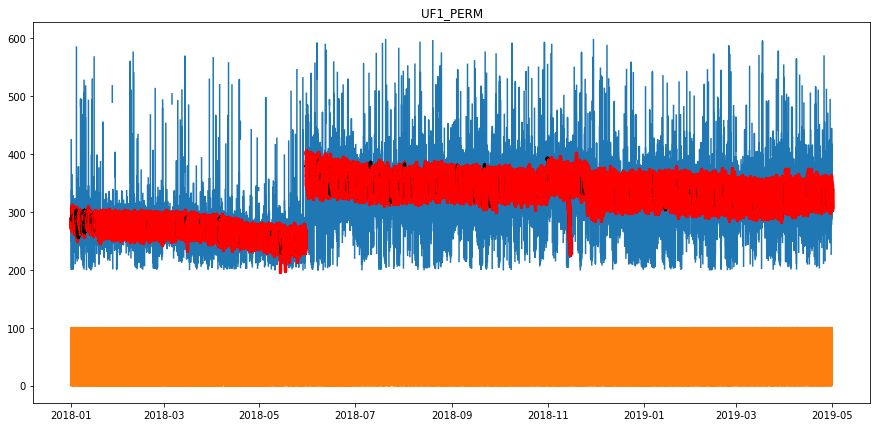

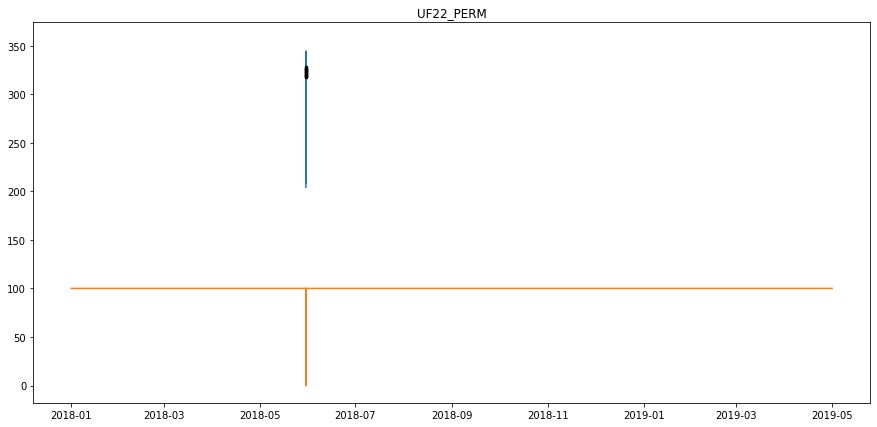

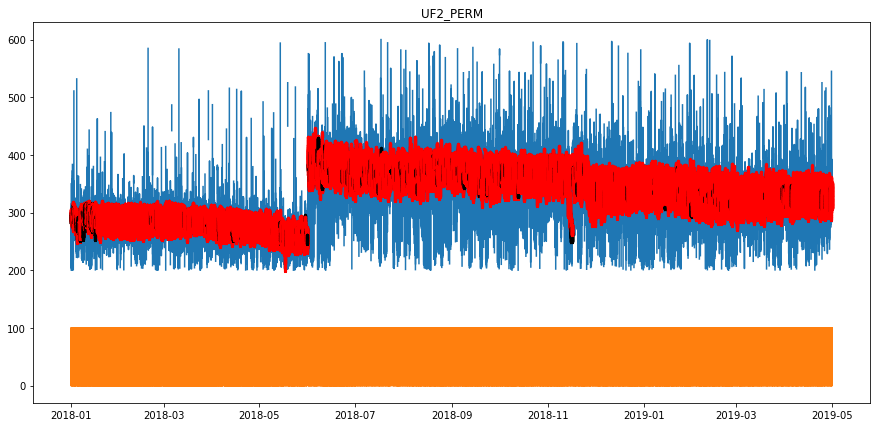

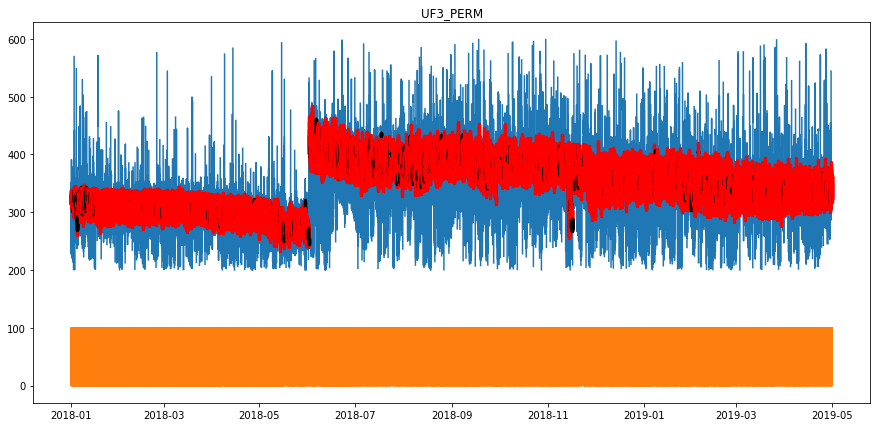

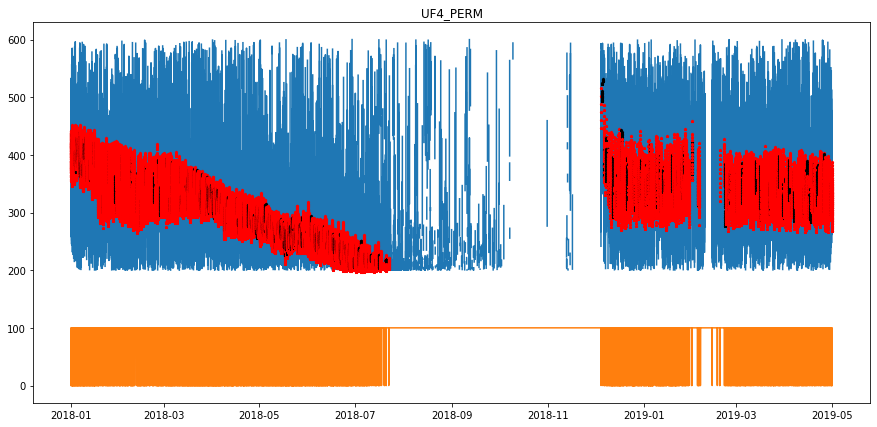

C:\Users\jens3109\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: Mean of empty slice


Done


In [6]:
"""
Find filtration and wash cycle data using the permeability
This cell takes a couple minutes to run
"""
x, wash_info = find_bw_perm(data_limits_applied, perm_name = '_PERM', perm_limit=200, min_distance=0, min_length=20, mean_points=10, plot_results=True)
wash_uv = calc_wash_cycle_acc254(x, wash_info)
print('Done')

##### Create dataset with calculated variables

In [8]:
calculated_variables = pd.DataFrame()

for ix in range(1, number_of_membranes + 1):
    wash_time_d = wash_info['UF' + str(ix) + '_PERM']['stop_time']-wash_info['UF' + str(ix) + '_PERM']['start_time']
    wash_cycle_length = wash_time_d.dt.total_seconds()/60
    prod_time_d = wash_info['UF' + str(ix) + '_PERM']['start_time']-wash_info['UF' + str(ix) + '_PERM']['stop_time'].shift(1)
    prod_cycle_length = prod_time_d.dt.total_seconds()/60
    restoration = wash_info['UF' + str(ix) + '_PERM']['stopping_vals']-wash_info['UF' + str(ix) + '_PERM']['starting_vals']
    calculated_variables['restoration_UF' + str(ix)] = restoration
    calculated_variables['wash_cyclelength_UF' + str(ix)] = wash_cycle_length
    calculated_variables['prod_cyclelength_UF' + str(ix)] = prod_cycle_length
    calculated_variables['derivative_UF' + str(ix)] = wash_info['UF' + str(ix) + '_PERM']['reg_coeffs']
    calculated_variables['AccUV_UF' + str(ix)] = wash_uv['UF' + str(ix) + '_FLUX']['AccUV']
    calculated_variables['cycle_datetime_UF' + str(ix)] = wash_info['UF' + str(ix) + '_PERM']['start_time']
    calculated_variables['accUV_cycle_datetime_UF' + str(ix)] = wash_uv['UF' + str(ix) + '_FLUX']['CycleDateTime']

print('Done')
#calculated_variables.to_csv('calculated_vars.csv')

Done


#### Find LAST TMP after AIT and temperature compensate
###### this can't be done without data from text files. Specifically the signals UF_XXX_L_TMP. But you can go on to the next step without this cell working/running this cell anyway

In [9]:
temperature = data_limits_applied['TEMP_CALC']
last_tmp_array = []
for uf_ix in range(1, number_of_membranes + 1):

    last_tmp = data_limits_applied['UF' + str(uf_ix) + '_L_TMP']
    ait_beg = data_limits_applied['UF' + str(uf_ix) + '_AIT_BEG']
    ait_beg_times = data_limits_applied.index[np.diff(ait_beg, append=1)==-1]
    tmp_diff_times = data_limits_applied.index[np.diff(last_tmp, append=1)!=0]
    tmp_df = last_tmp[tmp_diff_times]
    values = []

    for ix in range(len(ait_beg_times)-1):
        first_value_after = np.max(tmp_df[ait_beg_times[ix]:ait_beg_times[ix+1]])
        correction = 0.002024 * ((42.5 + temperature[ait_beg_times[ix]])**1.5)   
        values.append(first_value_after*correction)
    last_tmp_array.append(pd.DataFrame(data=values, index=ait_beg_times[:-1], columns=['UF' + str(uf_ix) + '_LAST_TMP_CORR']))
    

KeyError: 'UF1_L_TMP'

### Merge input data and calculated variables

##### Note the comment at the end of this code, depending on if you were able to run the previous cell, you might need to adjust this code

In [10]:
all_vars = data_limits_applied.copy()
for ix in range(1, number_of_membranes + 1):
    
    temp_df_1 = wash_info['UF' + str(ix) + '_PERM'][['stopping_vals']]
    temp_df_1.index = pd.to_datetime(wash_info['UF' + str(ix) + '_PERM']['stop_time'])
    temp_df_1.columns = temp_df_1.columns + '_UF' + str(ix)
    
    temp_df_2 = wash_info['UF' + str(ix) + '_PERM'][['starting_vals']]
    temp_df_2.index = pd.to_datetime(wash_info['UF' + str(ix) + '_PERM']['start_time'])
    temp_df_2.columns = temp_df_2.columns + '_UF' + str(ix)
    
    temp_df_3 =  calculated_variables[['restoration_UF' + str(ix), 'wash_cyclelength_UF' + str(ix), 'prod_cyclelength_UF' + str(ix), 'derivative_UF' + str(ix)]]
    temp_df_3.index = pd.to_datetime(calculated_variables['cycle_datetime_UF' + str(ix)])

    # commented away because signals UF_XXX_L_TMP doesn't exist in case text files with data has not been
    # included when running the data import notebook.
    # If you have the UF_XXX_L_TMP data, use the first of the two lines below instead of the second
    #merged_wash_info = temp_df_1.join([temp_df_2, temp_df_3, last_tmp_array[ix-1]], how='outer')
    merged_wash_info = temp_df_1.join([temp_df_2, temp_df_3], how='outer')
    merged_wash_info_resampled = merged_wash_info.resample('1T').median().ffill().dropna()
    all_vars = all_vars.join(merged_wash_info_resampled)
    

## Overview plotting - interactive
- Run the cell
- Use the start and stop dates to select date interval
- Set the number of minutes to use for median filter (minimum 1)
- Choose which variables to plot, hold ctrl-key to select multiple options. 
- The more variables and high time resolution will take more time to load
- The figure is updated when clicking "Run Interact"

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Layout
import cufflinks as cf
cf.go_offline()

plot_df = all_vars

start_date = widgets.DatePicker(description='Start', disabled=False, value=pd.to_datetime('2018-01-01'))
display(start_date)
stop_date = widgets.DatePicker(description='Stop', disabled=False, value=pd.to_datetime('2020-04-01'))
display(stop_date)

median_slider = widgets.IntSlider(min=1, max=60, step=1, value=10, description='Median filter [min]')
display(median_slider)

list_layout = widgets.Layout(width='100%')


y_list_1 = widgets.SelectMultiple(
    options=list(plot_df.select_dtypes('number').columns),
    value=[plot_df.select_dtypes('number').columns[0]],
    description='Left Y',
    disabled=False, layout=Layout(width='40%', height='200px'))

y_list_2 = widgets.SelectMultiple(
    options=list(plot_df.select_dtypes('number').columns),
    value=[plot_df.select_dtypes('number').columns[0]],
    description='Right Y',
    disabled=False, layout=Layout(width='40%', height='200px'))

lists = widgets.HBox(children=[y_list_1, y_list_2],layout=list_layout)
#display(lists)


def update_plot(y_1=y_list_1, y_2=y_list_2):
    
    df = all_vars.resample(str(median_slider.value) + 'T').median()
    df = df.loc[start_date.value:stop_date.value]
    list_1 = list(y_1)
    list_2 = list(y_2)
    plot_df = df[list_1 + list_2]
    display(plot_df.iplot(secondary_y=list_2))
    
man = interact_manual(update_plot, y1=y_list_1)
    

NameError: name 'all_vars' is not defined

#### Overview scatter plot for calculated variables
- Run the cell
- The figure is updated when changing either of the variables

In [12]:
@interact
def scatter_plot(x=list(calculated_variables.select_dtypes('number').columns), 
                y= list(calculated_variables.select_dtypes('number').columns)[1:]):
    display(calculated_variables.iplot(x=x, y=y, kind='scatter', xTitle=x.title(), yTitle=y.title(), mode='markers'))

interactive(children=(Dropdown(description='x', options=('restoration_UF1', 'wash_cyclelength_UF1', 'prod_cycl…

# Plotting
The following segment creates static plots described by their header

### Backwash restoration - time series

<IPython.core.display.Javascript object>


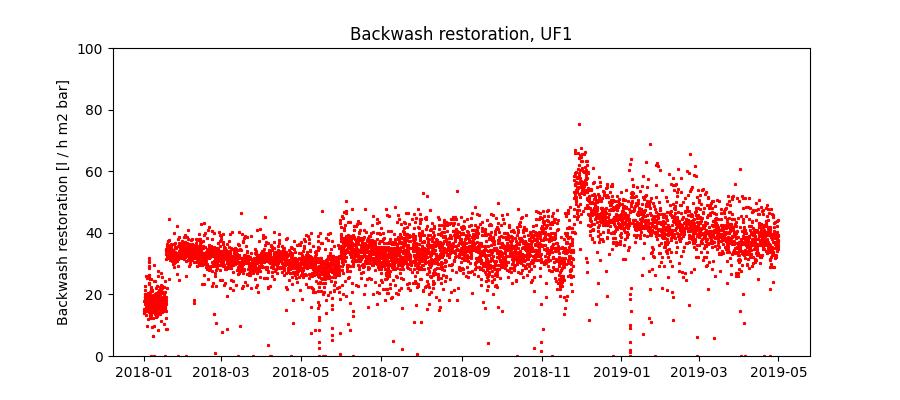

<IPython.core.display.Javascript object>


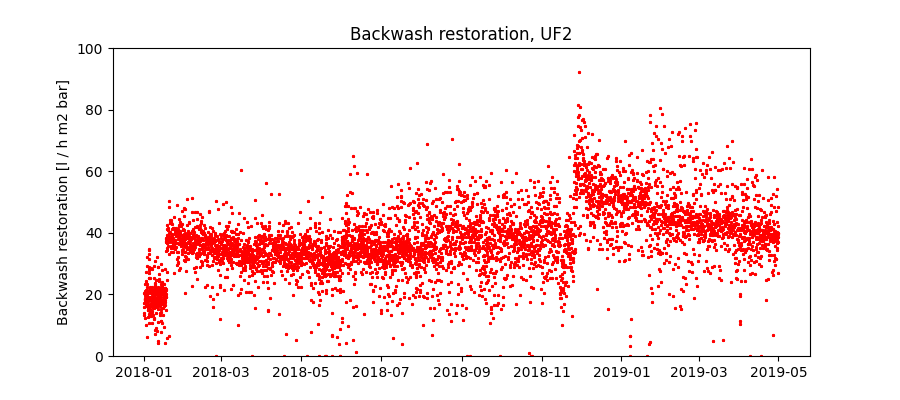

<IPython.core.display.Javascript object>


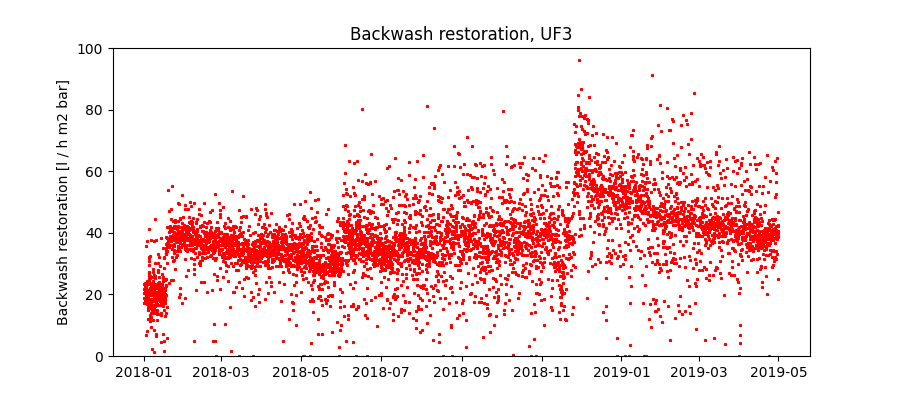

<IPython.core.display.Javascript object>


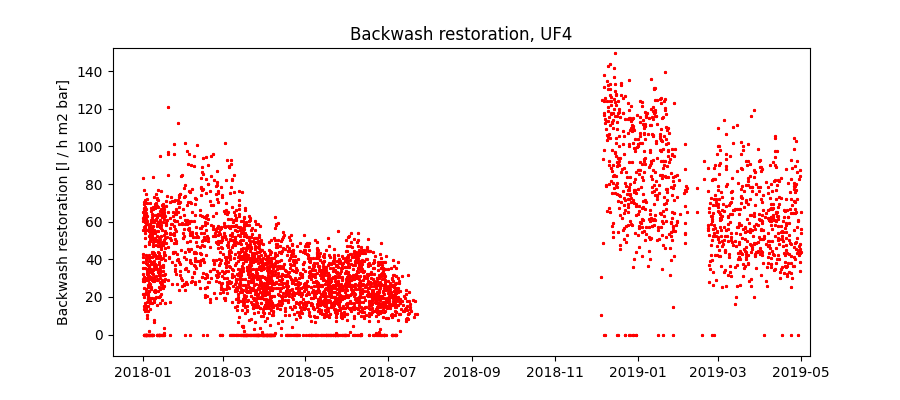

In [13]:
%matplotlib notebook
for ix in range(1, number_of_membranes + 1):
    plt.figure(figsize=(9, 4))
    
    plt.title('Backwash restoration, UF' + str(ix))
    plt.plot(wash_info['UF' + str(ix) + '_PERM']['stop_time'], 
             wash_info['UF' + str(ix) + '_PERM']['stopping_vals']-wash_info['UF' + str(ix) + '_PERM']['starting_vals'], 'r*', markersize=2)
    plt.ylabel('Backwash restoration [l / h m2 bar]')
    plt.ylim(0, 100)
    plt.show()

### Filtration cycle derivative - time series

<IPython.core.display.Javascript object>


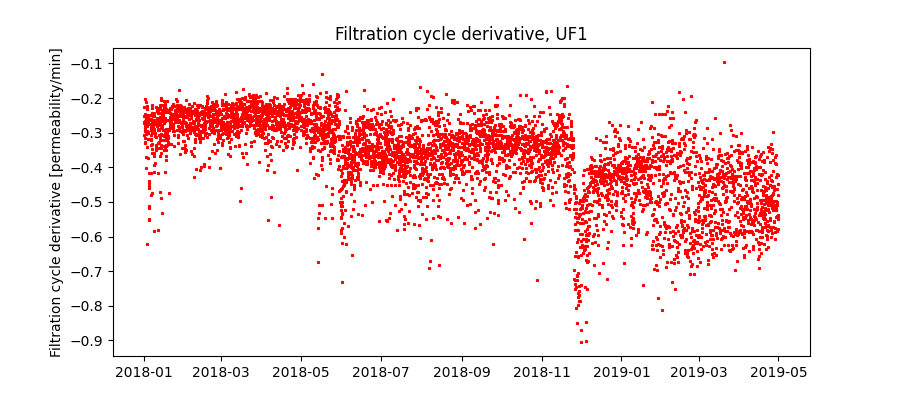

<IPython.core.display.Javascript object>


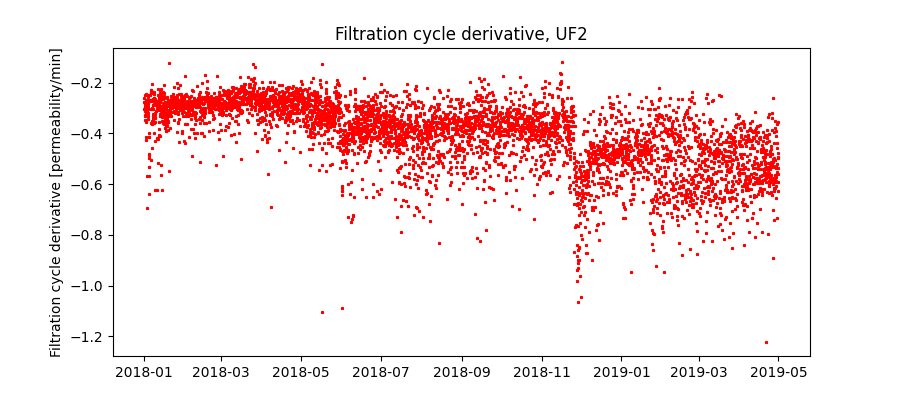

<IPython.core.display.Javascript object>


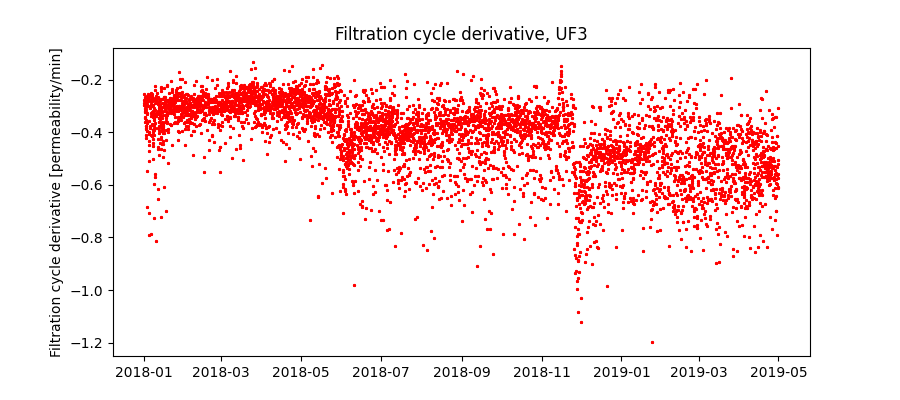

<IPython.core.display.Javascript object>


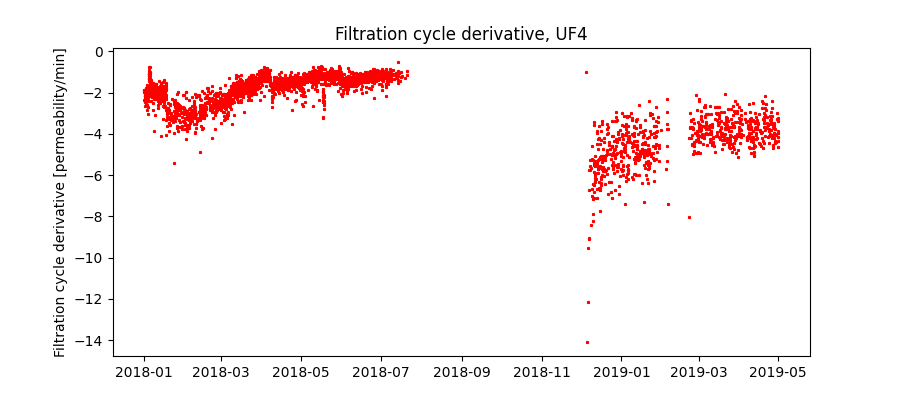

In [14]:
for ix in range(1,number_of_membranes + 1):
    plt.figure(figsize=(9, 4))
    plt.title('Filtration cycle derivative, UF' + str(ix))
    plt.plot(wash_info['UF' + str(ix) + '_PERM']['stop_time'], wash_info['UF' + str(ix) + '_PERM']['reg_coeffs'], 'r*',markersize=2)
    plt.ylabel('Filtration cycle derivative [permeability/min]')
    plt.show()


### TMP after AIT temperature compensated

### This can't be executed without the signals UF_XXX_L_TMP

<IPython.core.display.Javascript object>


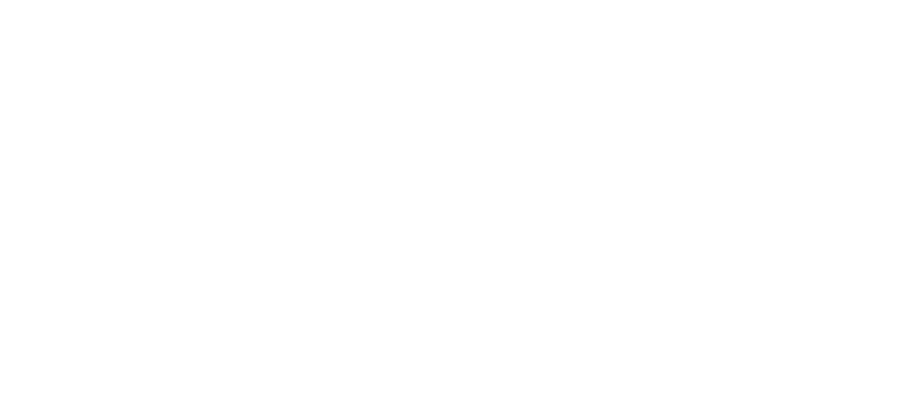

NameError: name 'tmp' is not defined

In [16]:
c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(figsize=(9,4))
for ix in range(1, number_of_membranes + 1):
    
    plt.title('TMP after AIT')
    tmp = last_tmp_array[ix-1]['UF' + str(ix) + '_LAST_TMP_CORR']
    plt.plot(tmp,  '*',color=c[ix-1], markersize=5, label='UF1:' + str(ix))
    plt.ylabel('TMP [bar]')
    
    y = tmp.dropna().values  
    x = np.array(range(len(y)))
    
    remove_values_ix = (y<(np.nanmedian(y)-0.1)) | (y>(np.nanmedian(y)+0.1))
    x = x[~remove_values_ix].reshape(-1,1)
    y = y[~remove_values_ix].reshape(-1,1)
    reg = sklm.LinearRegression().fit(x, y)
    plt.plot(tmp.dropna().index[~remove_values_ix], reg.predict(x), color=c[ix-1], linewidth=0.5, label='k=' + '{:.2E}'.format(reg.coef_[0][0]))
    print(reg.coef_)

#plt.minorticks_on()
plt.grid()
plt.legend()
plt.show()

### Start and stop points for each filtration cycle - time series

<IPython.core.display.Javascript object>


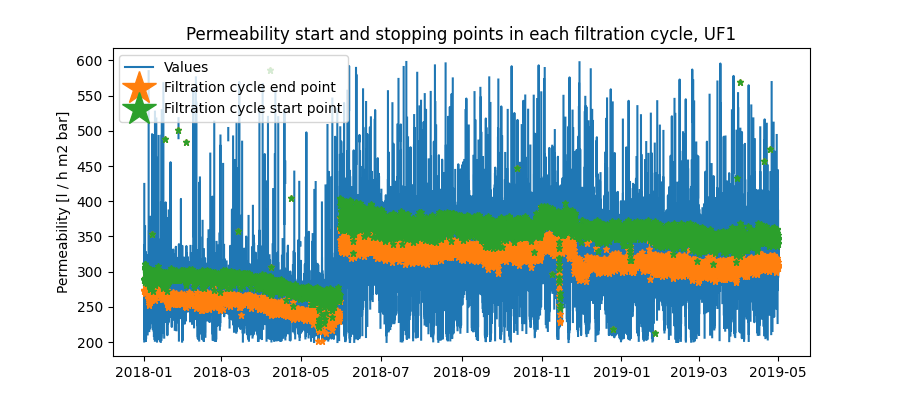

<IPython.core.display.Javascript object>


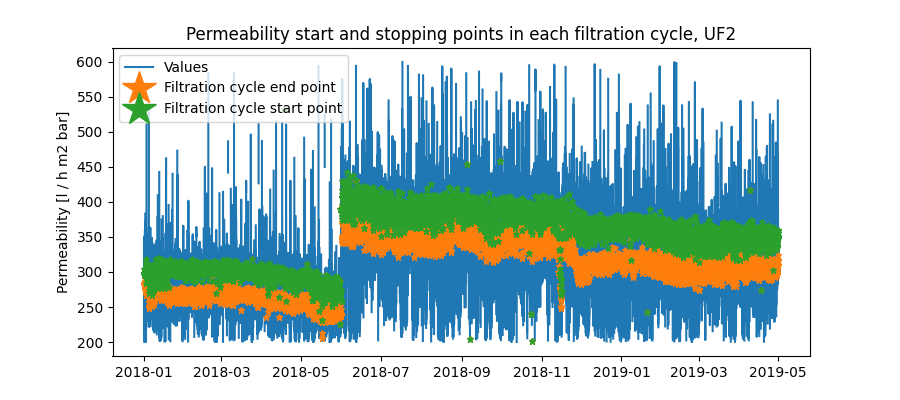

<IPython.core.display.Javascript object>


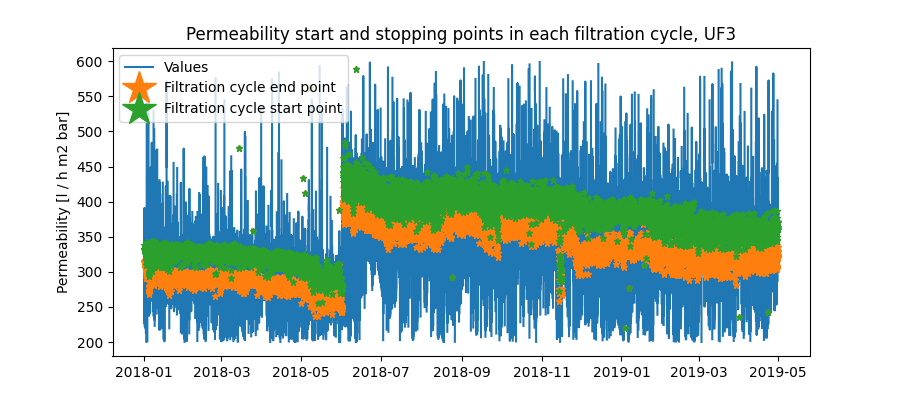

<IPython.core.display.Javascript object>


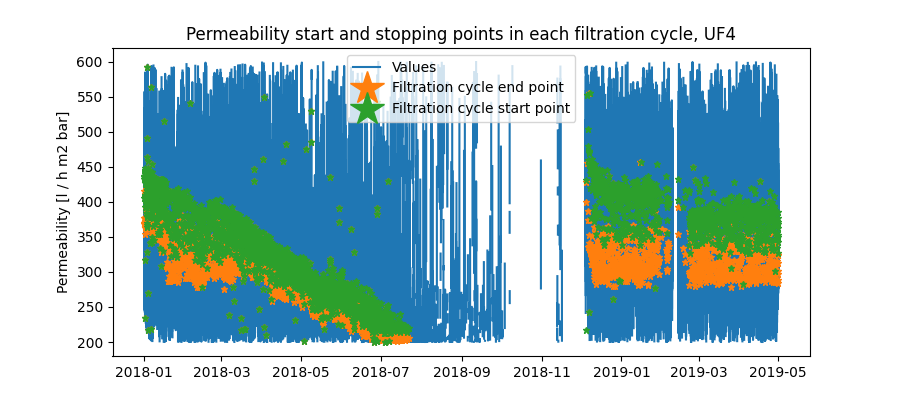

In [17]:
%matplotlib notebook
for ix in range(1, number_of_membranes + 1):
    plt.figure(figsize=(9,4))
    plt.title('Permeability start and stopping points in each filtration cycle, UF' + str(ix))
    plt.plot(data_limits_applied['UF' + str(ix) + '_PERM'])
    plt.plot(wash_info['UF' + str(ix) + '_PERM']['start_time'],wash_info['UF' + str(ix) + '_PERM']['starting_vals'], '*', markersize=5)
    plt.plot(wash_info['UF' + str(ix) + '_PERM']['stop_time'],wash_info['UF' + str(ix) + '_PERM']['stopping_vals'], '*', markersize=5)
    plt.legend(['Values', 'Filtration cycle end point','Filtration cycle start point'], markerscale=5)
    plt.ylabel('Permeability [l / h m2 bar]')
    plt.show()

<IPython.core.display.Javascript object>


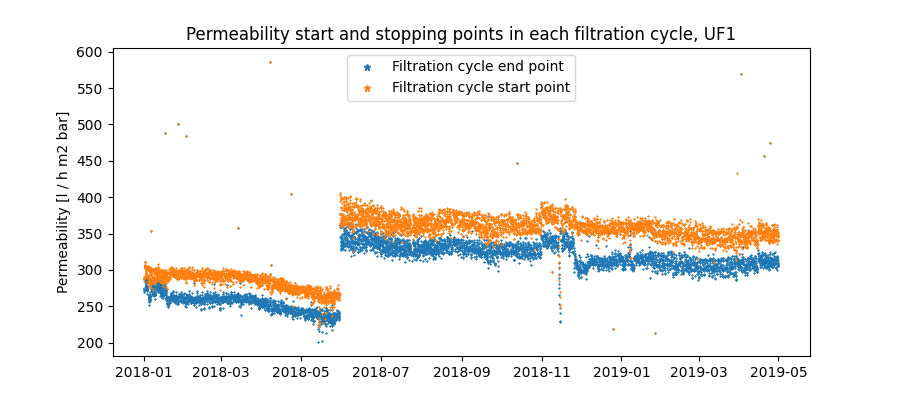

<IPython.core.display.Javascript object>


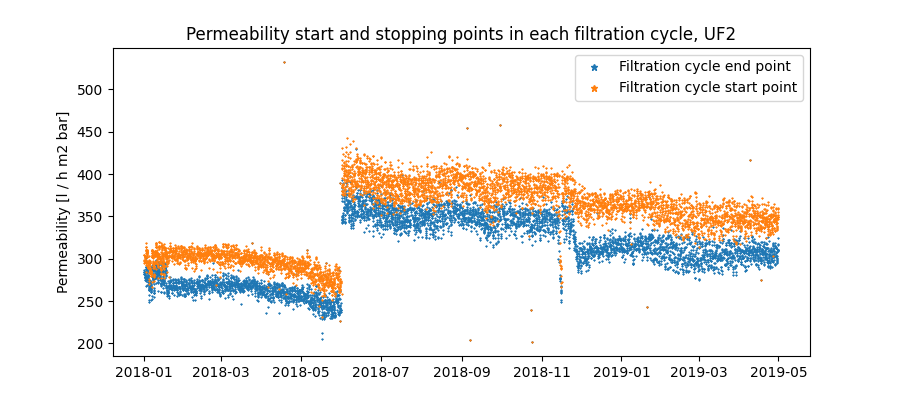

<IPython.core.display.Javascript object>


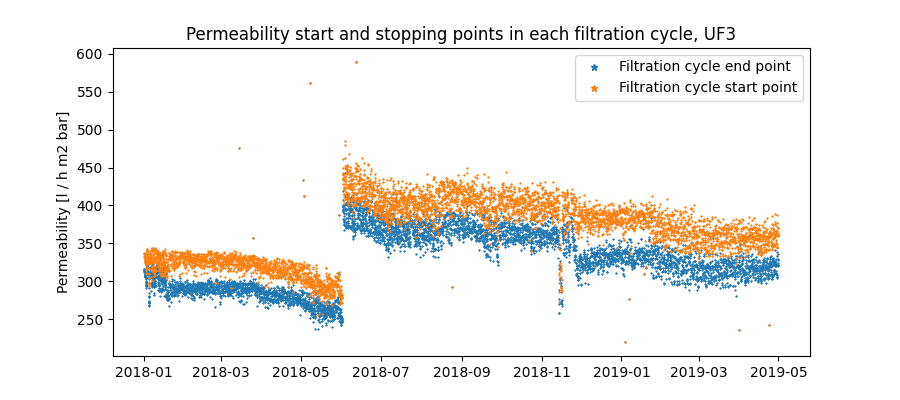

<IPython.core.display.Javascript object>


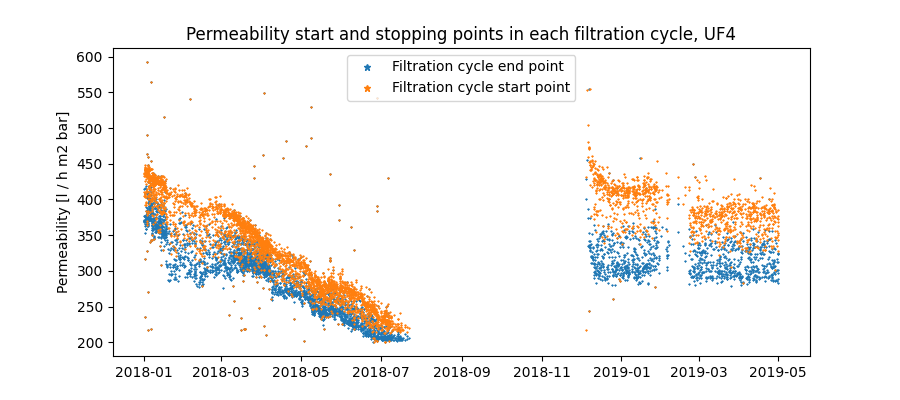

In [18]:
for ix in range(1,number_of_membranes + 1):
    plt.figure(figsize=(9,4))
    plt.title('Permeability start and stopping points in each filtration cycle, UF' + str(ix))
    plt.plot(wash_info['UF' + str(ix) + '_PERM']['start_time'],wash_info['UF' + str(ix) + '_PERM']['starting_vals'], '*', markersize=1)
    plt.plot(wash_info['UF' + str(ix) + '_PERM']['stop_time'],wash_info['UF' + str(ix) + '_PERM']['stopping_vals'], '*', markersize=1)
    plt.legend(['Filtration cycle end point','Filtration cycle start point'], markerscale=5)
    plt.ylabel('Permeability [l / h m2 bar]')
    plt.show()

### Backwash resotration + temperature - time series

<IPython.core.display.Javascript object>


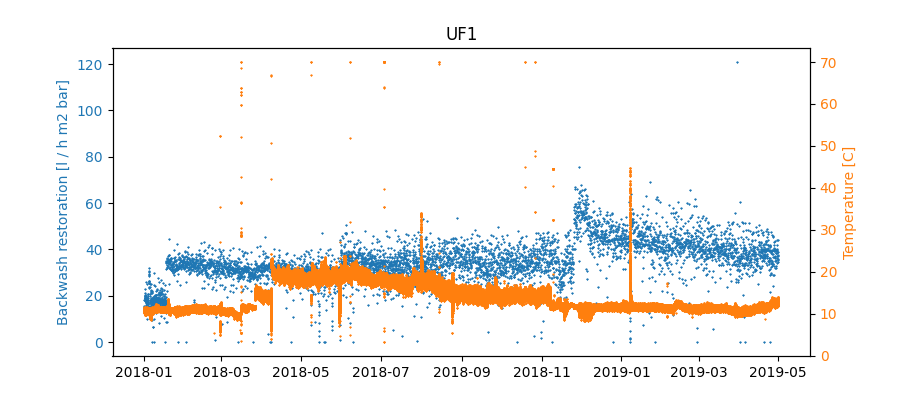

<IPython.core.display.Javascript object>


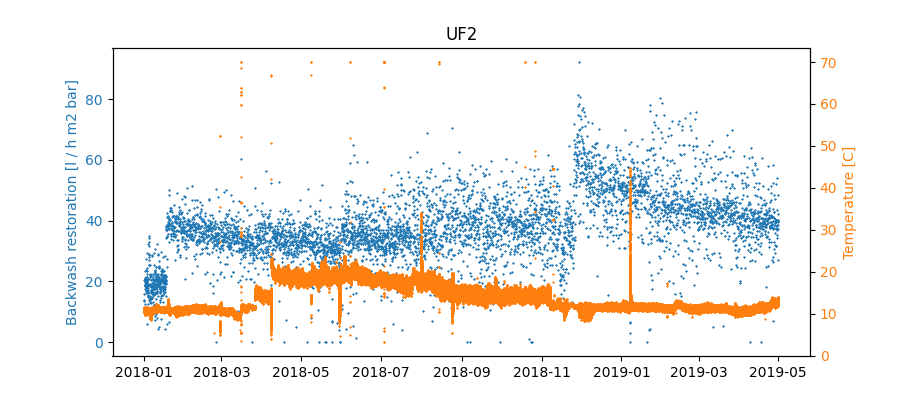

<IPython.core.display.Javascript object>


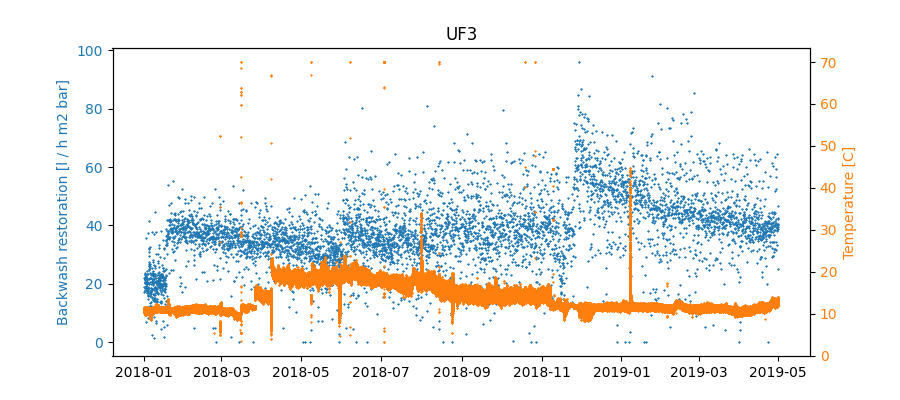

<IPython.core.display.Javascript object>


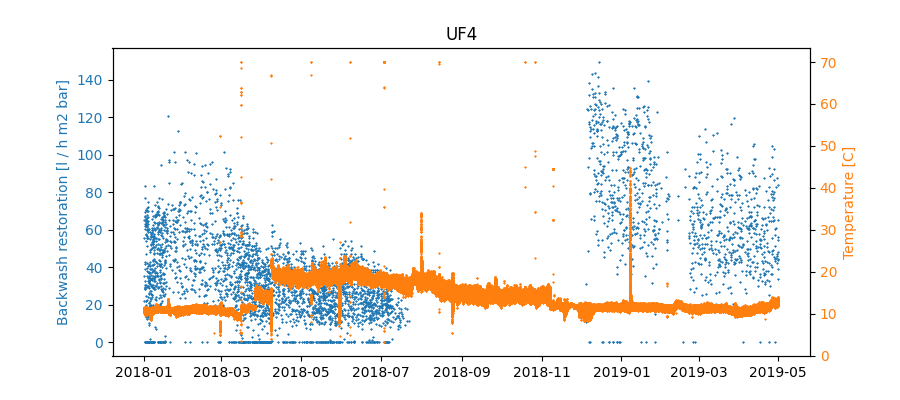

In [22]:
for ix in range(1,number_of_membranes + 1):
    fig, ax1 = plt.subplots(figsize=(9,4))
    c = 'tab:blue'
    plt.title('UF' + str(ix))
    ax1.plot(wash_info['UF' + str(ix) + '_PERM']['stop_time'], 
             wash_info['UF' + str(ix) + '_PERM']['stopping_vals']-wash_info['UF' + str(ix) + '_PERM']['starting_vals'], '*', markersize=1, color=c)
    ax1.tick_params(axis='y', labelcolor=c)
    ax1.set_ylabel('Backwash restoration [l / h m2 bar]', color=c)
    #ax1.set_ylim([150, 450])
    
    ax2 = ax1.twinx()
    c = 'tab:orange'
    ax2.plot(data_limits_applied['TEMP_CALC'], '*', markersize=1, color=c)
    ax2.tick_params(axis='y', labelcolor=c)
    ax2.set_ylabel('Temperature [C]', color=c)
    plt.show()

### Wash cycle restoration vs filtration cycle derivatives - scatter

In [ ]:

for ix in range(1,number_of_membranes + 1):
    plt.figure()
    plt.title('UF' + str(ix))
    plt.scatter(calculated_variables['restoration_UF' + str(ix)], calculated_variables['derivative_UF' + str(ix)], s=2)
    plt.xlabel('Wash cycle restoration [l / h m2 bar]')
    plt.ylabel('Filtration cycle derivative [permeability/min]')
    plt.xlim([0, 150])
    plt.ylim([-1.5, 0])
    plt.show()

### Filtration cycle derivative + filtration cycle length - time series

In [ ]:
for ix in range(1,number_of_membranes + 1):
    fig, ax1 = plt.subplots(figsize=(9,4))
    c = 'tab:blue'
    plt.title('UF' + str(ix))
    ax1.plot(calculated_variables['cycle_datetime_UF' + str(ix)],calculated_variables['prod_cyclelength_UF' + str(ix)], '*', markersize=1, color=c)
    ax1.tick_params(axis='y', labelcolor=c)
    ax1.set_ylabel('Filtration cycle length [min]', color=c)
    ax1.set_ylim([0, 400])
    
    ax2 = ax1.twinx()
    c = 'tab:orange'
    ax2.plot(calculated_variables['cycle_datetime_UF' + str(ix)], calculated_variables['derivative_UF'+ str(ix)], '*', markersize=1, color=c)
    ax2.tick_params(axis='y', labelcolor=c)
    ax2.set_ylabel('Filtration cycle derivative [permeability/min]', color=c)
    plt.show()

### Filtration cycle derivative + Frac GV - time series

In [ ]:
%matplotlib notebook
for ix in range(1,number_of_membranes + 1):
    fig, ax1 = plt.subplots(figsize=(9,4))
    c = 'tab:blue'
    plt.title('UF' + str(ix))
    ax1.plot(data_limits_applied['FRAC_GV'], '*', markersize=1, color=c)
    ax1.tick_params(axis='y', labelcolor=c)
    ax1.set_ylabel('Fraction GV [%]', color=c)
    ax1.set_ylim([0, 35])
    
    ax2 = ax1.twinx()
    c = 'tab:orange'
    ax2.plot(calculated_variables['cycle_datetime_UF' + str(ix)], calculated_variables['derivative_UF'+ str(ix)], '*', markersize=1, color=c)
    ax2.tick_params(axis='y', labelcolor=c)
    ax2.set_ylabel('Filtration cycle derivative [permability/min]', color=c)
    plt.show()

### Filtration cycle derivative + filtration flux - time series

In [ ]:
for ix in range(1,number_of_membranes + 1):
    fig, ax1 = plt.subplots(figsize=(9,4))
    c = 'tab:blue'
    plt.title('UF' + str(ix))
    ax1.plot(calculated_variables['cycle_datetime_UF' + str(ix)], calculated_variables['derivative_UF'+ str(ix)], '*', markersize=1, color=c)
    ax1.set_ylabel('Filtration cycle derivative', color=c)
    ax1.tick_params(axis='y', labelcolor=c)
    
    
    ax2 = ax1.twinx()
    c = 'tab:orange'
    ax2.plot(wash_uv['UF' + str(ix) + '_FLUX']['CycleDateTime'],wash_uv['UF' + str(ix) + '_FLUX']['Mean_flux'], '*', markersize=1, color=c)
    ax2.set_ylabel('Average filtration flux', color=c)
    ax2.tick_params(axis='y', labelcolor=c)
    
    plt.show()

### Ackumulativ UV254 + matarvatten UV254 - tidsserie

In [ ]:
for ix in range(1,number_of_membranes + 1):
    fig, ax1 = plt.subplots(figsize=(9,4))
    c = 'tab:blue'
    plt.title('Accumulative UV254 vs feed water UV254, UF' + str(ix))
    ax1.plot(data_limits_applied['MAT_UV254'], '*', markersize=1, color=c)
    #ax1.plot(data_limits_applied['PERM_UV254'], '*', markersize=1, color='k')
    ax1.tick_params(axis='y', labelcolor=c)
    ax1.set_ylabel('Feed UV254', color=c)
    #plt.legend(['', 'PERM_UV254', ''])
    
    ax2 = ax1.twinx()
    c = 'tab:orange'
    ax2.plot(calculated_variables['accUV_cycle_datetime_UF' + str(ix)], calculated_variables['AccUV_UF' + str(ix)], '*', markersize=1, color=c)
    ax2.tick_params(axis='y', labelcolor=c)
    ax2.set_ylabel('Accumulative UF254', color=c)
    plt.show()

### Accumulated UV254 + derivatives - time series

In [ ]:
for ix in range(1,number_of_membranes + 1):
    fig, ax1 = plt.subplots(figsize=(9,4))
    c = 'tab:blue'
    plt.title('Accumulative UV254 vs filtration cycle derivate, UF' + str(ix))
    ax1.plot(calculated_variables['cycle_datetime_UF' + str(ix)], calculated_variables['derivative_UF'+ str(ix)], '*', markersize=1, color=c)
    ax1.tick_params(axis='y', labelcolor=c)
    ax1.set_ylabel('Filtration cycle derivative', color=c)
    
    ax2 = ax1.twinx()
    c = 'tab:orange'
    ax2.plot(calculated_variables['accUV_cycle_datetime_UF' + str(ix)], calculated_variables['AccUV_UF' + str(ix)], '*', markersize=1, color=c)
    ax2.tick_params(axis='y', labelcolor=c)
    ax2.set_ylabel('Accumulative UF254', color=c)
    plt.show()

### Accumulated UV254 vs PERM starting point - time series

In [ ]:
for ix in range(1,number_of_membranes + 1):
    fig, ax1 = plt.subplots(figsize=(9,4))
    c = 'tab:blue'
    plt.title('Accumulative UV254 vs PERM after BW, UF' + str(ix))
    
    ax1.plot(wash_info['UF' + str(ix) + '_PERM']['start_time'], wash_info['UF' + str(ix) + '_PERM']['starting_vals'], '*', markersize=1, color=c)
    ax1.tick_params(axis='y', labelcolor=c)
    ax1.set_ylabel('Permeability after backwash', color=c)
    
    ax2 = ax1.twinx()
    c = 'tab:orange'
    ax2.plot(calculated_variables['accUV_cycle_datetime_UF' + str(ix)], calculated_variables['AccUV_UF' + str(ix)], '*', markersize=1, color=c)
    ax2.tick_params(axis='y', labelcolor=c)
    ax2.set_ylabel('Accumulative UF254', color=c)
    ax2.set_ylim([0, 70000])
    plt.show()


### Accumulated UV 254 vs Filtration cycle length

In [ ]:
for ix in range(1,number_of_membranes + 1):
    plt.figure()
    x = np.array(wash_uv['UF' + str(ix) + '_FLUX']['CycleLength'].dropna()).reshape(-1,1)
    y = np.array(wash_uv['UF' + str(ix) + '_FLUX']['AccUV'].dropna()).reshape(-1,1)
    plt.scatter(x, y, s=1, c='k')
    elastic = sklm.ElasticNet().fit(x, y)
    lasso= sklm.Lasso().fit(x, y)
    linear = sklm.LinearRegression().fit(x, y)
    ridge = sklm.Ridge().fit(x, y)
    plt.plot(x, elastic.predict(x), 'r')
    plt.plot(x, ridge.predict(x), 'b')
    plt.plot(x, linear.predict(x), 'g')
    plt.plot(x, lasso.predict(x), 'm')
    print(ridge.coef_)
    plt.xlim([0, 400])
    plt.ylim([0, 40000])
    plt.ylabel('Accumulated UV254')
    plt.xlabel('Cycle length')
    plt.title('UF' + str(ix) + ' acc UV254 / cycle length')
    plt.show()

### Backwash restoration vs feed dose

In [ ]:
for ix in range(1,number_of_membranes + 1):
    fig, ax1 = plt.subplots(figsize=(9,4))
    c = 'tab:blue'
    plt.title('Backwash restoration vs feed dose, UF' + str(ix))
    ax1.plot(data_limits_applied['PAC_DOS'].resample('5H').median(), '*', markersize=1, color=c)
    ax1.tick_params(axis='y', labelcolor=c)
    ax1.set_ylabel('Feed dose', color=c)
    
    ax2 = ax1.twinx()
    c = 'tab:orange'
    ax2.plot(calculated_variables['cycle_datetime_UF' + str(ix)], calculated_variables['restoration_UF' + str(ix)], '*', markersize=1, color=c)
    ax2.tick_params(axis='y', labelcolor=c)
    ax2.set_ylabel('Backwash restoration', color=c)
    plt.show()

### Accumulated volume  + filtration cycle length - time series

In [ ]:
for ix in range(1, number_of_membranes + 1):
    
    fig, ax1 = plt.subplots(figsize=(9,4))
    c = 'tab:blue'
    plt.title('Cycle limits, UF1:' + str(ix))
    ax1.plot(wash_uv['UF' + str(ix) + '_FLUX']['CycleDateTime'], wash_uv['UF' + str(ix) + '_FLUX']['AccVol'], '*', markersize=1, color=c)
    ax1.tick_params(axis='y', labelcolor=c)
    ax1.set_ylabel('Accumulated volume', color=c)
    
    ax2 = ax1.twinx()
    c = 'tab:orange'
    ax2.plot(wash_uv['UF' + str(ix) + '_FLUX']['CycleDateTime'], wash_uv['UF' + str(ix) + '_FLUX']['CycleLength'], '*', markersize=1, color=c)
    ax2.tick_params(axis='y', labelcolor=c)
    ax2.set_ylabel('Cycle length', color=c)

    plt.show()


#### Feed and permeate quality

In [ ]:
fig, ax1 = plt.subplots(figsize=(9,4))
c = 'tab:blue'
plt.title('Feed water quality')
ax1.plot(all_vars['MAT_COLOR'], '*', markersize=1, color=c)
ax1.tick_params(axis='y', labelcolor=c)
ax1.set_ylabel('Color [Pt-Co]', color=c)
ax1.set_ylim([5, 30])

ax2 = ax1.twinx()
c = 'tab:orange'
ax2.plot(all_vars['MAT_UV254'], '*', markersize=1, color=c)
ax2.tick_params(axis='y', labelcolor=c)
ax2.set_ylabel('UV254 [1/m]', color=c)
ax2.set_ylim([4, 12])
plt.show()


fig, ax1 = plt.subplots(figsize=(9,4))
c = 'tab:blue'
plt.title('Permeate water quality')
ax1.plot(all_vars[['PERM_COLOR', 'PERM_COLOR_2']], '*', markersize=1, color=c)
ax1.tick_params(axis='y', labelcolor=c)
ax1.set_ylabel('Color [Pt-Co]', color=c)
ax1.set_ylim([1, 6])

ax2 = ax1.twinx()
c = 'tab:orange'
ax2.plot(all_vars[['PERM_UV254', 'PERM_UV254_2']],'*', markersize=1, color=c)
ax2.tick_params(axis='y', labelcolor=c)
ax2.set_ylabel('UV254 [1/m]', color=c)
ax2.set_ylim([2, 6])
plt.show()





# PCA - principal component analysis
Principal component analysis is used to gain further understanding of the relationship between variables.
Find further details here: http://miljostatistik.se/PCA.html

- Score plot: Each point is a measurement point, colored by time (blue=start, red=stop). <br/> R2X[0] + R2X[1] is an estimation on how much of the variance in the data that is explained by the first two principal components (t0 and t1). This should be as close to 1 as possible. 
- Loading plot: Each point is a specific variable. The plot shows how the principal components depend on the input variables. <br/> Variables close to eachother are positively correlated <br/> Variables on opposing side of the origin are negatively correlated <br/> Orthogonal variables are not correlated.

Analyzing the combination of score and loading plots can make you draw conclusions on how the process is changing over time. If for example the points in the score plot are moving towards the upper left corner, it probably indicates an increase of the variables in the upper left corner in the loading plot (or decrease of variables in the lower right corner that are negatively correlated). 

### PCA of calculated variables
The calculated variables for each membrane is used for PCA analysis

<IPython.core.display.Javascript object>


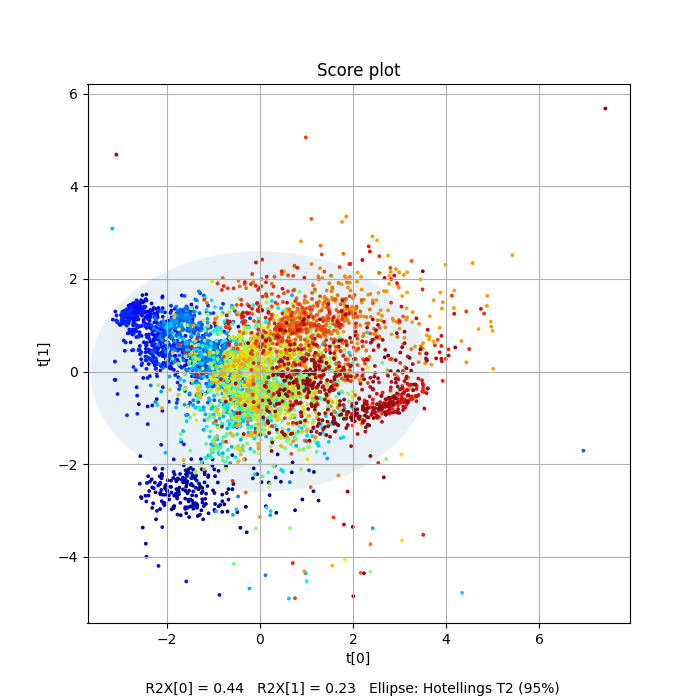

Setting index as coloring..


<IPython.core.display.Javascript object>


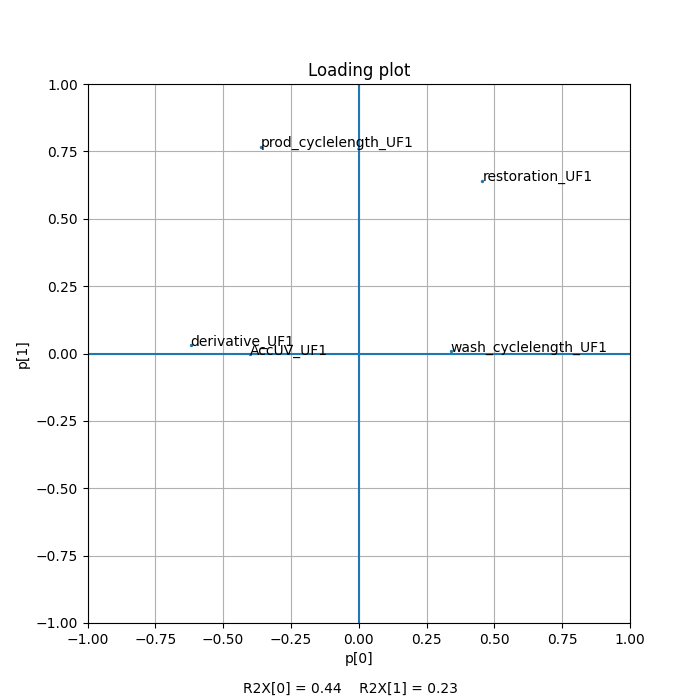

<IPython.core.display.Javascript object>


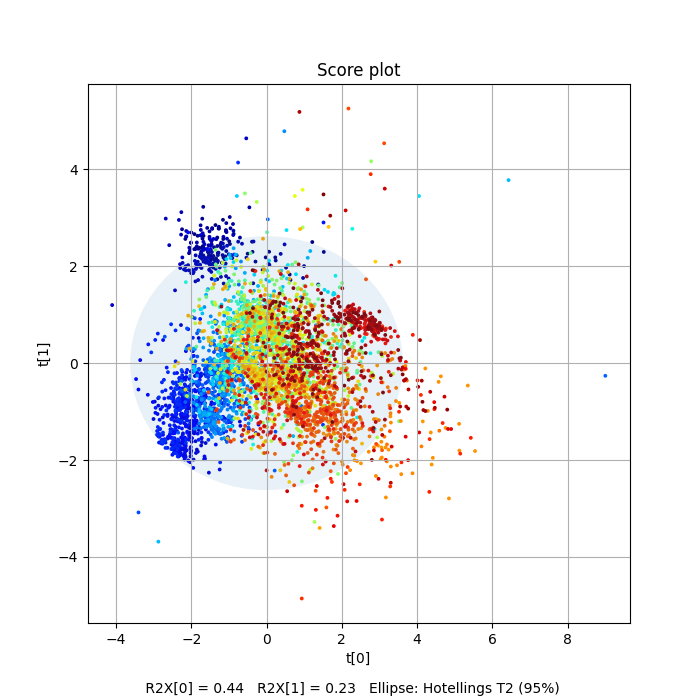

Setting index as coloring..


<IPython.core.display.Javascript object>


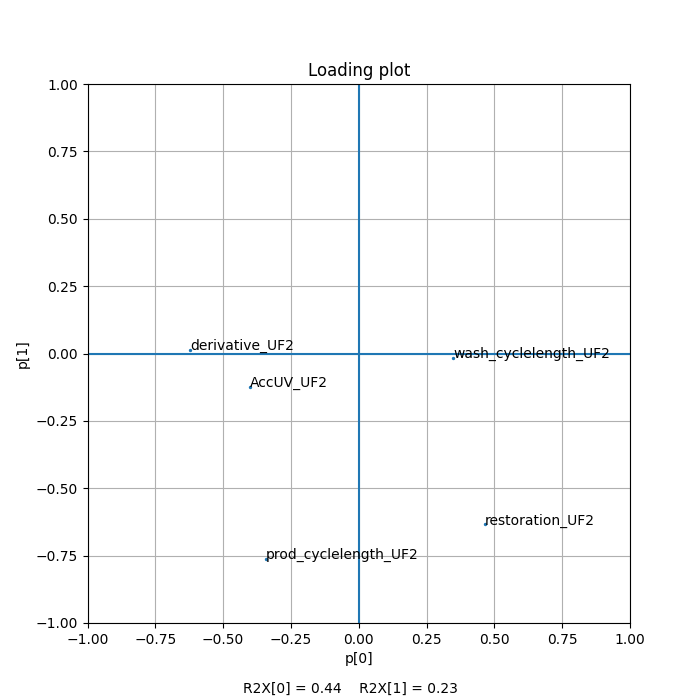

<IPython.core.display.Javascript object>


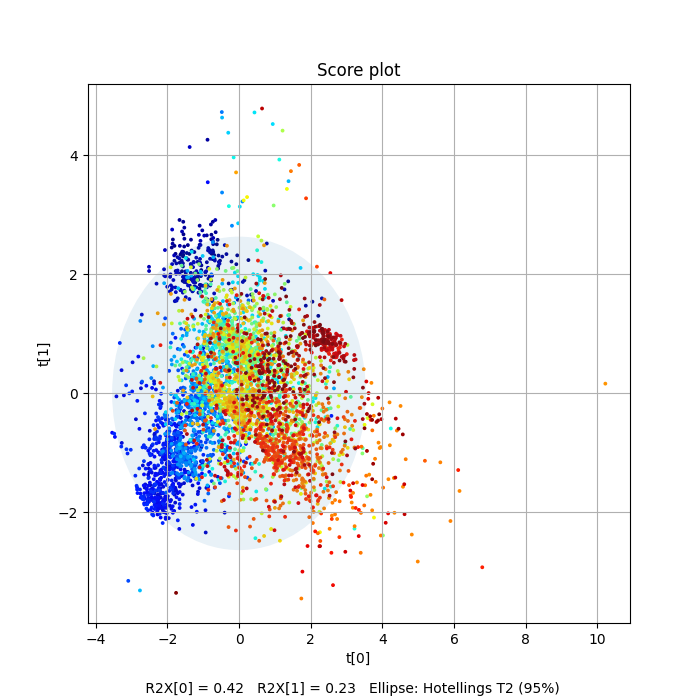

Setting index as coloring..


<IPython.core.display.Javascript object>


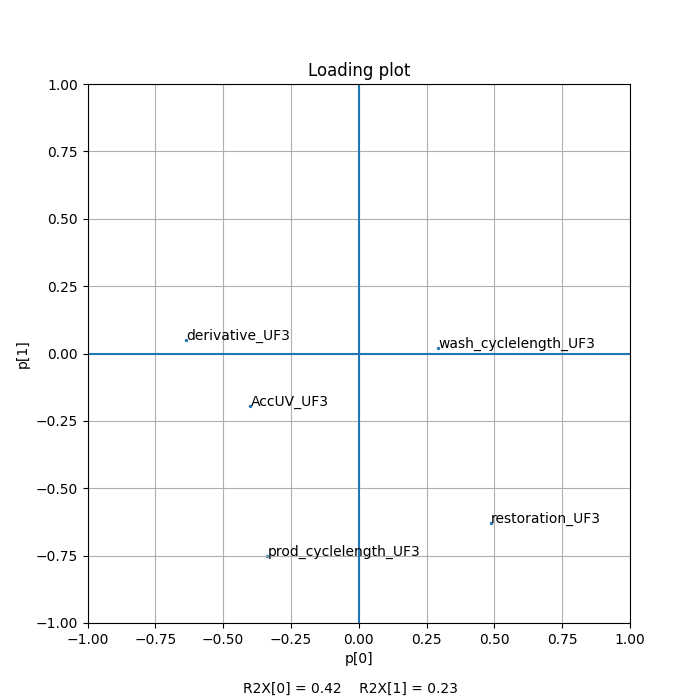

<IPython.core.display.Javascript object>


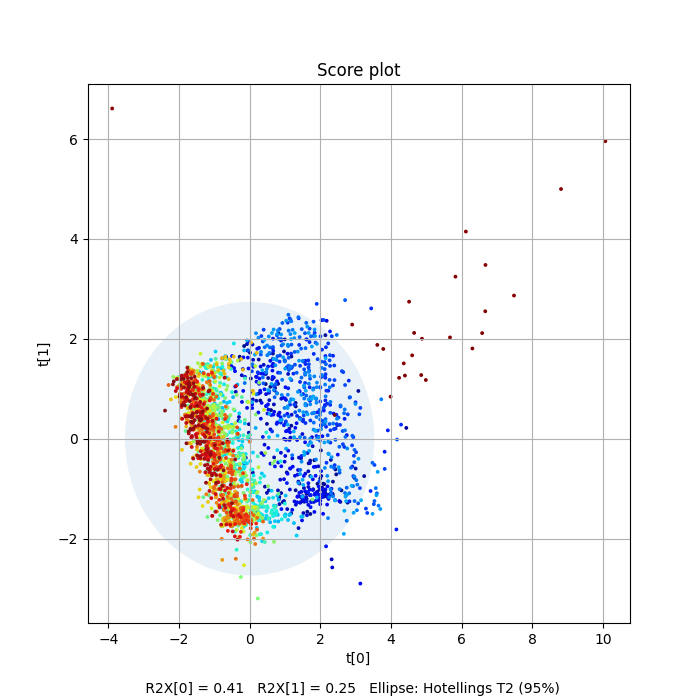

Setting index as coloring..


<IPython.core.display.Javascript object>


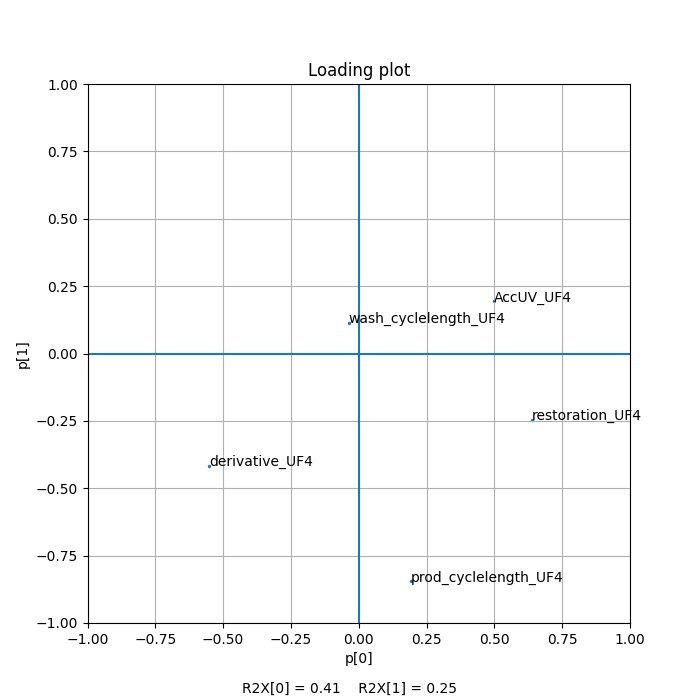

In [19]:
%matplotlib notebook
# import PCA
pca_df = calculated_variables.select_dtypes(exclude=['datetime'])

for ix in range(1,number_of_membranes + 1):
    cols = [s for s in pca_df.columns if str(ix) in s]
    pca = PCA(pca_df[cols])
    plt.figure(figsize=(7,7))
    pca.plot_scores(s=3)
    plt.figure(figsize=(7,7))
    pca.plot_loadings()

### PCA of original variables
Run the script and select which variables you would like to use for PCA analysis. Multiple selections are done by holding the ctrl-key. To run the analysis, click "Run interaction".

In [20]:
%matplotlib notebook

pca_df = all_vars.select_dtypes(exclude=['datetime'])  
y_list = widgets.SelectMultiple(
    options=list(pca_df.select_dtypes('number').columns),
    value=[pca_df.select_dtypes('number').columns[0]],
    description='Input',
    disabled=False, rows=len(list(pca_df.select_dtypes('number').columns)))

def update_plot(y=y_list):   
        
    plot_df = pca_df[list(y)]
    pca = PCA(plot_df.dropna(axis=1, how='all').dropna(axis=0))
    #pca = PCA(pca_df[cols].fillna(method='backfill').fillna(method='ffill').dropna(axis=1))
    plt.figure(figsize=(7,7))
    pca.plot_scores(s=3)
    plt.figure(figsize=(7,7))
    pca.plot_loadings()


interact_manual(update_plot, y_list = widgets.SelectMultiple(
    options=list(pca_df.select_dtypes('number').columns),
    value=[pca_df.select_dtypes('number').columns[0]],
    description='Input columns',
    disabled=False, rows=len(list(pca_df.select_dtypes('number').columns))));


interactive(children=(SelectMultiple(description='Input', index=(0,), options=('ENERGI_M3', 'FRAC_GV', 'MAT_CO…

### Plot everything to word document

<IPython.core.display.Javascript object>


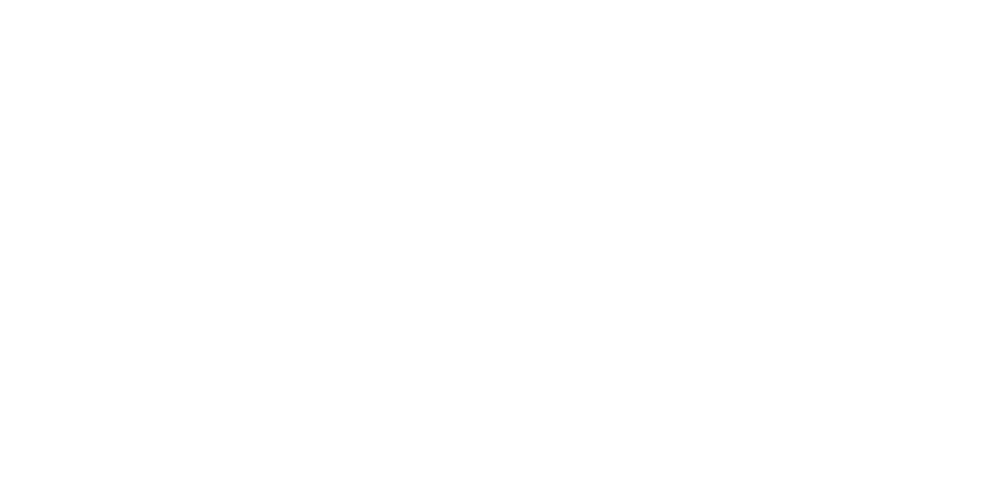

<IPython.core.display.Javascript object>


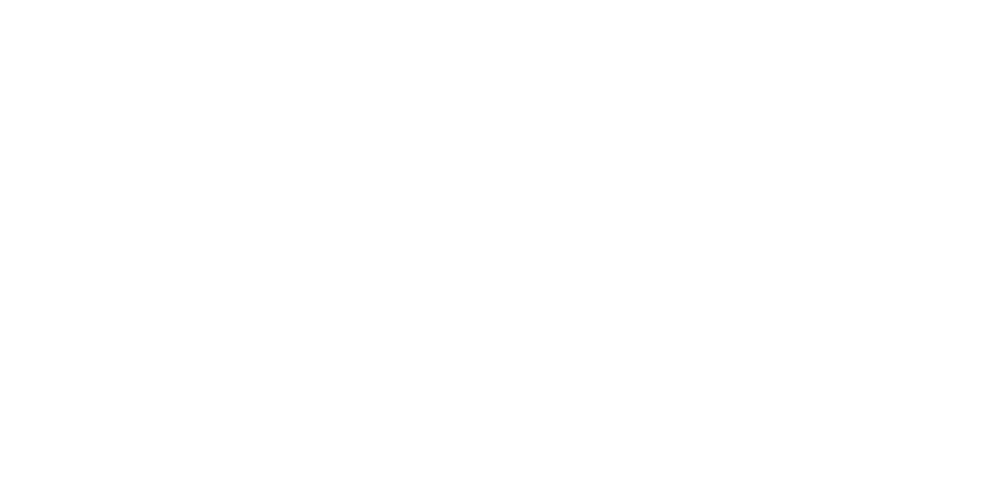

<IPython.core.display.Javascript object>


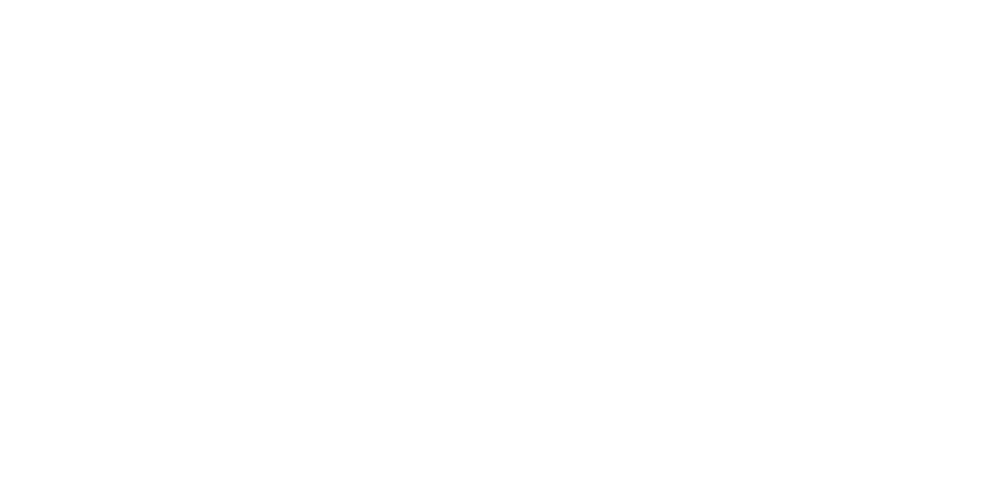

<IPython.core.display.Javascript object>


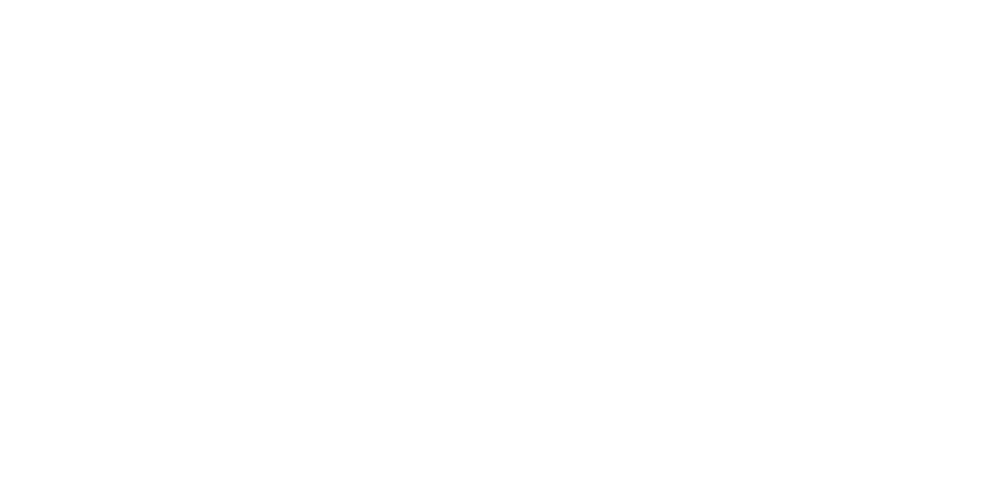

<IPython.core.display.Javascript object>


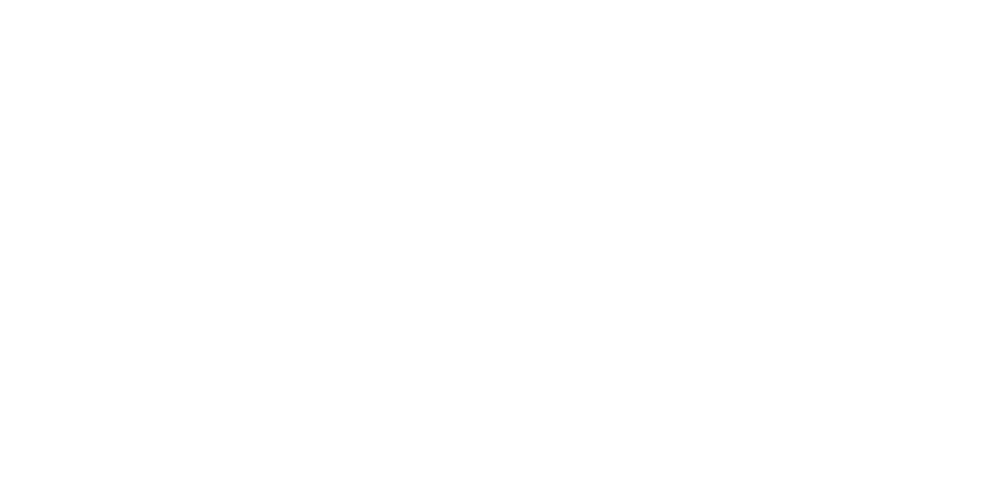

<IPython.core.display.Javascript object>


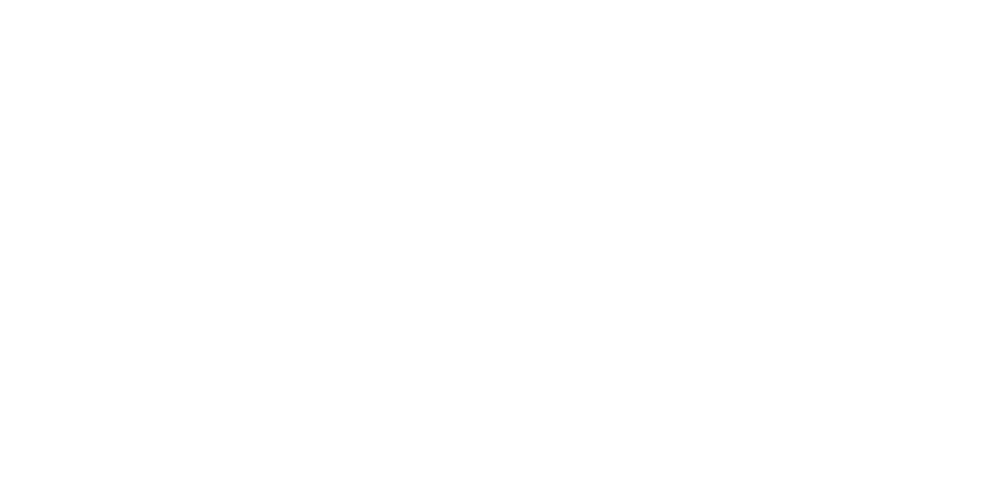

<IPython.core.display.Javascript object>


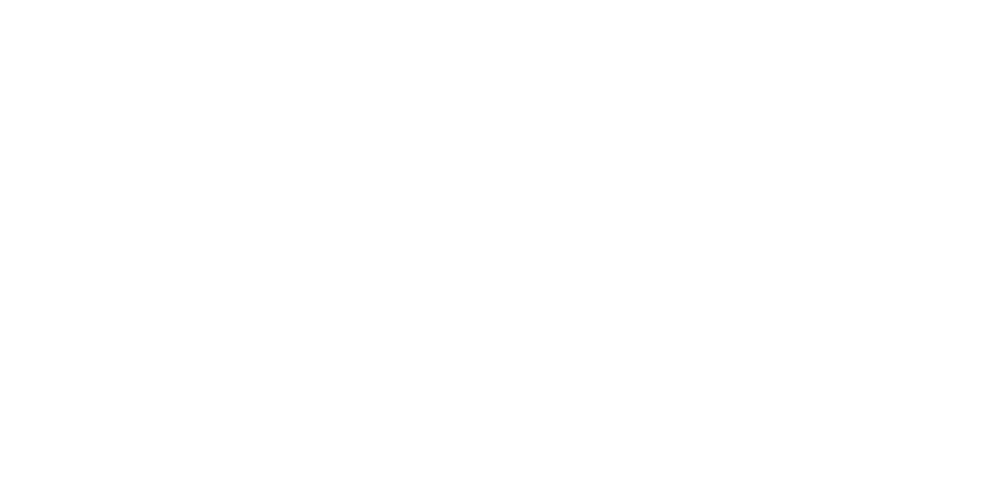

<IPython.core.display.Javascript object>


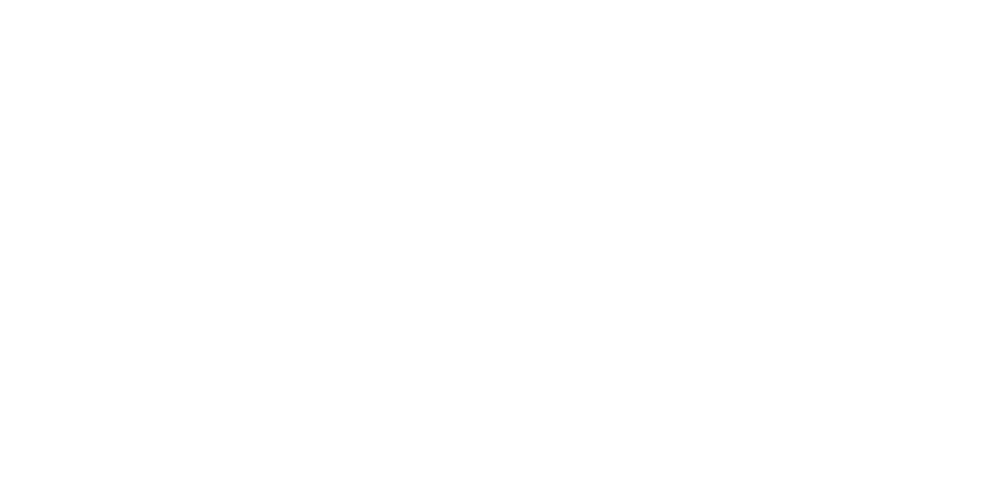

<IPython.core.display.Javascript object>


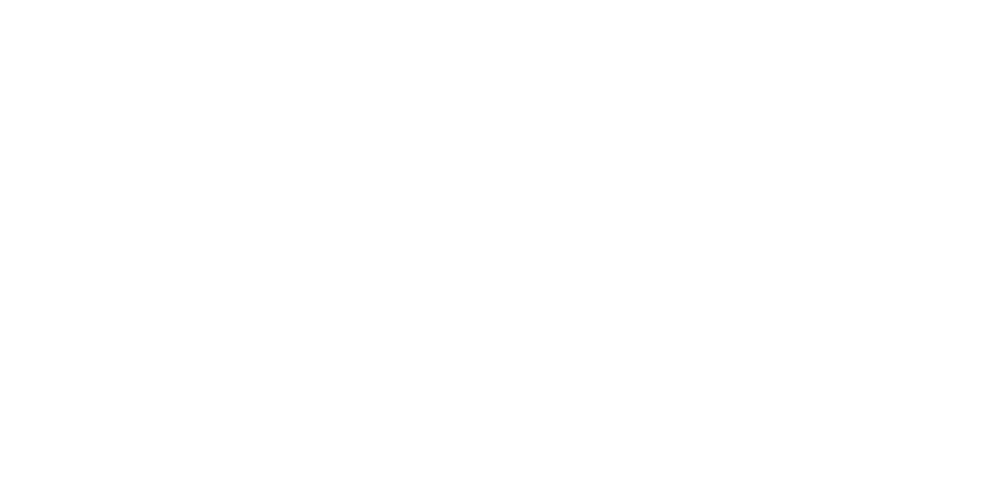

<IPython.core.display.Javascript object>


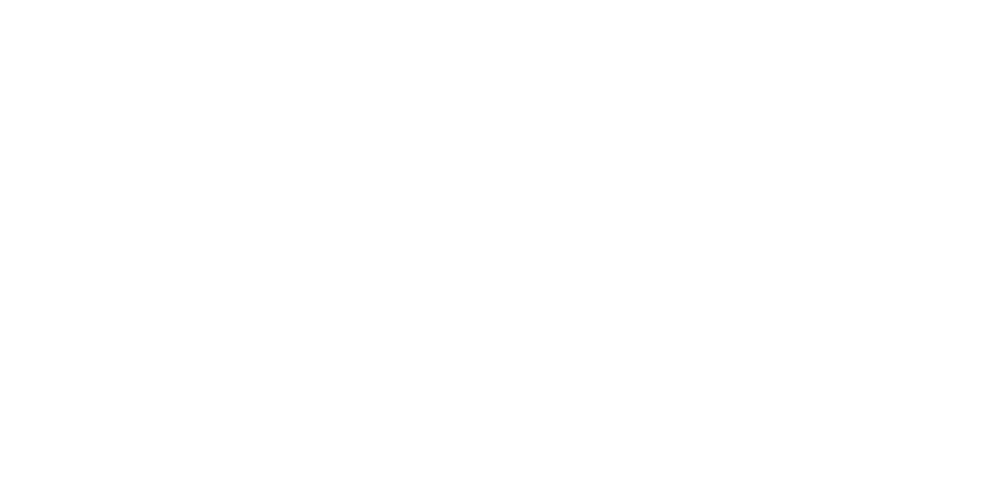

<IPython.core.display.Javascript object>


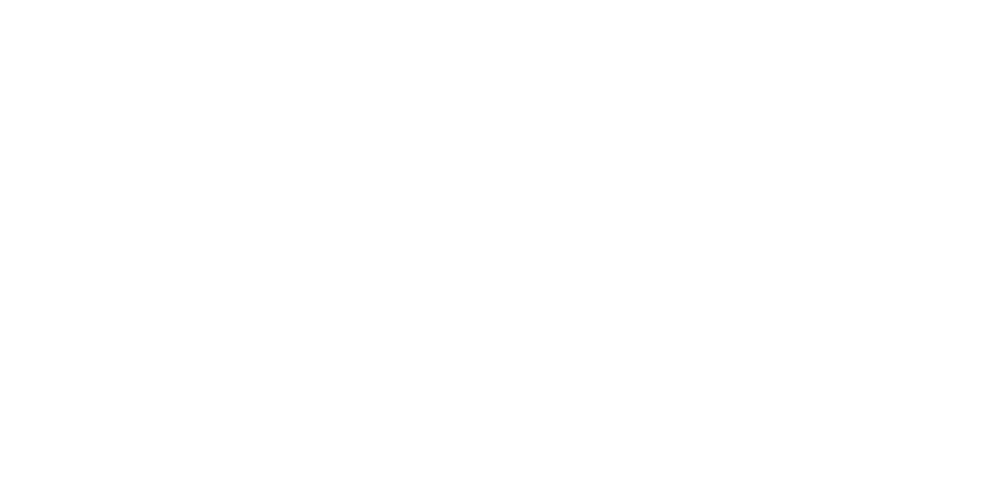

<IPython.core.display.Javascript object>


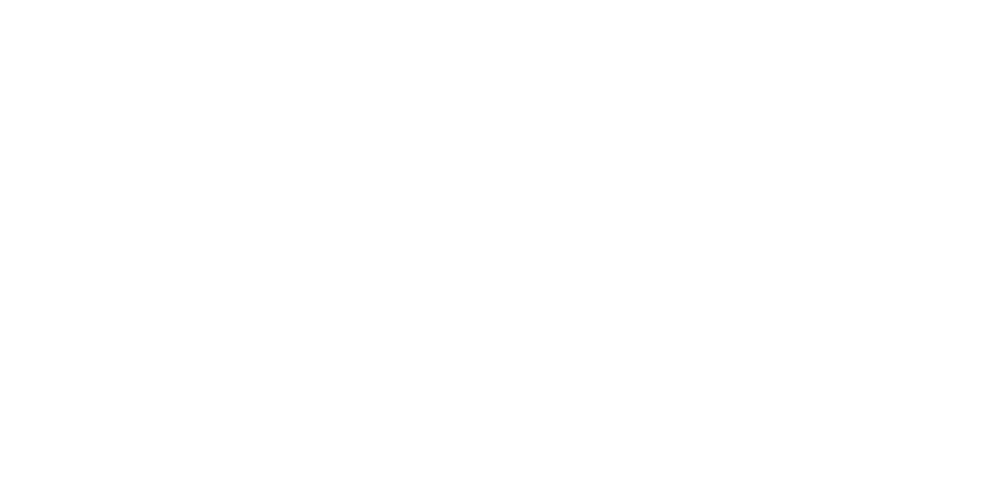

<IPython.core.display.Javascript object>


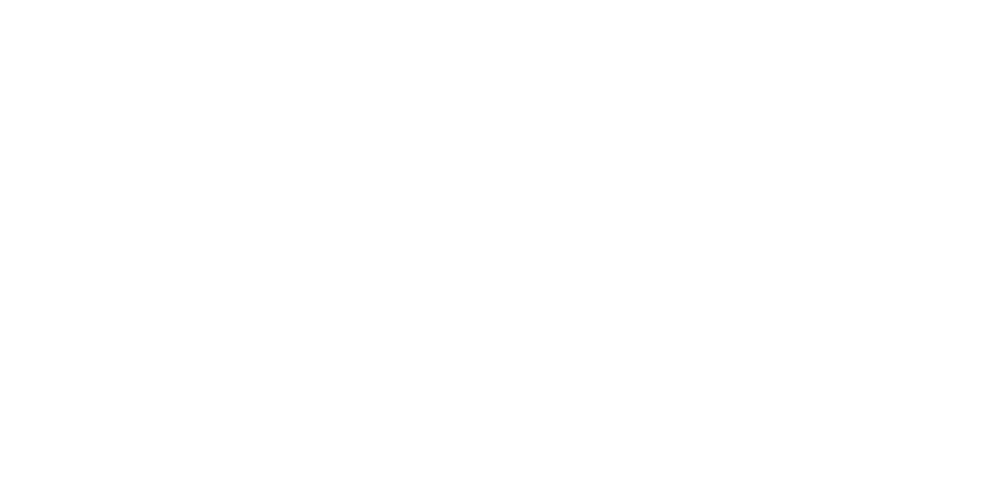

<IPython.core.display.Javascript object>


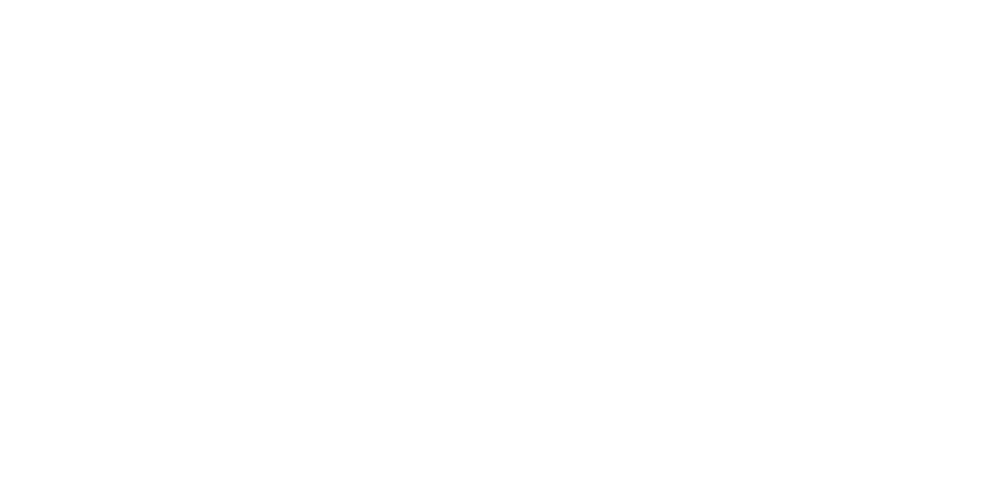

<IPython.core.display.Javascript object>


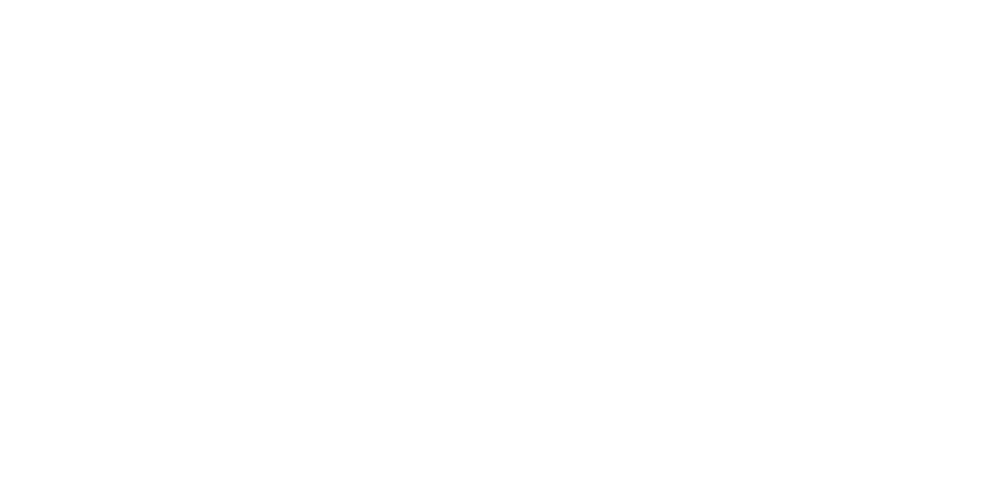

<IPython.core.display.Javascript object>


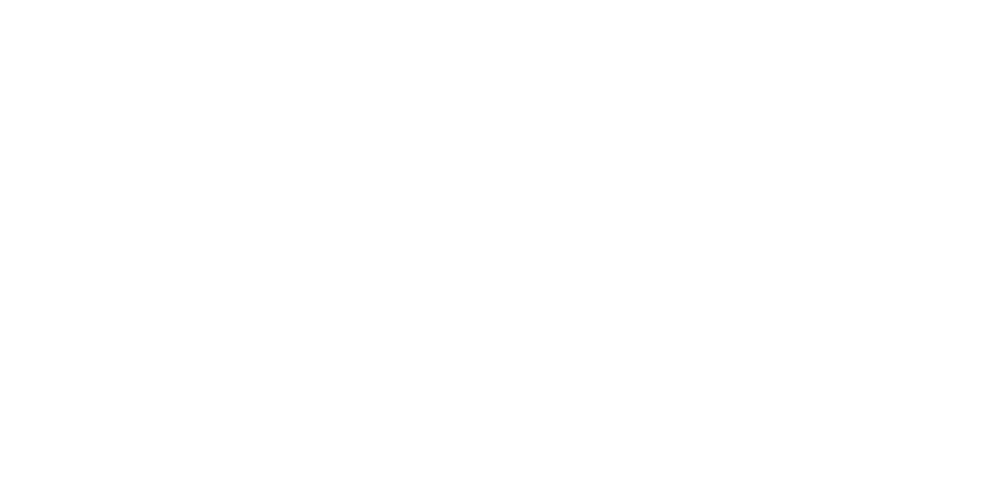

<IPython.core.display.Javascript object>


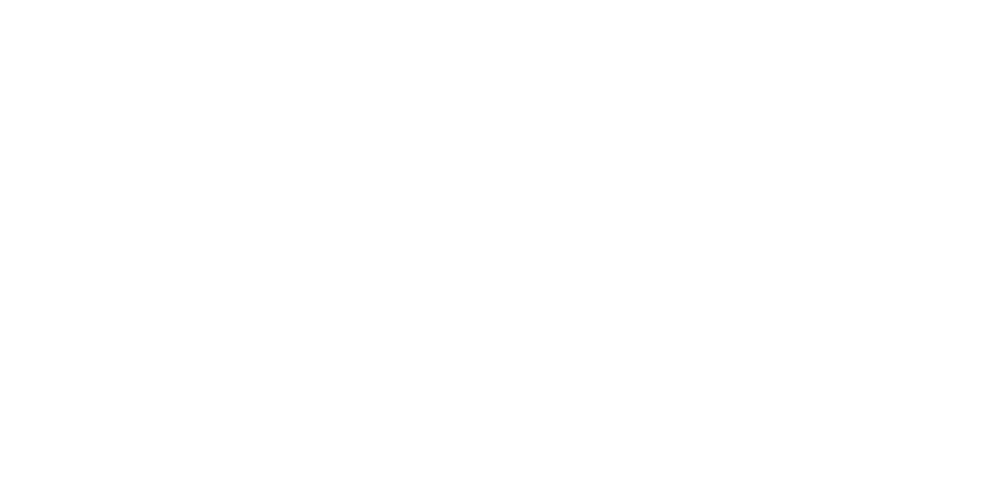

<IPython.core.display.Javascript object>


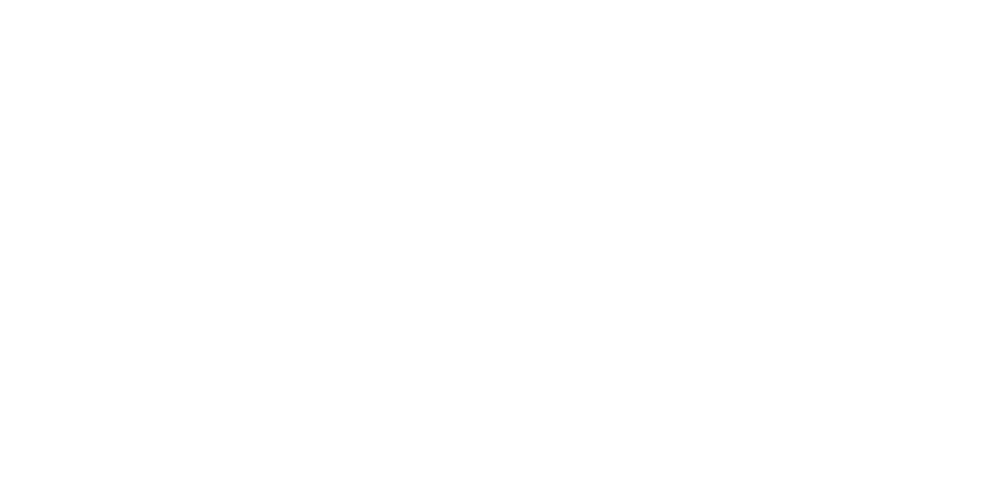

<IPython.core.display.Javascript object>


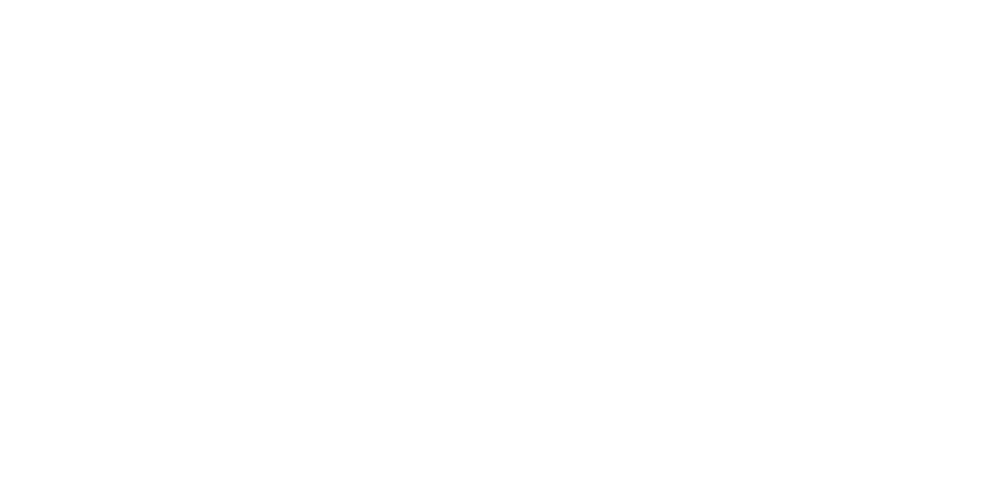

<IPython.core.display.Javascript object>


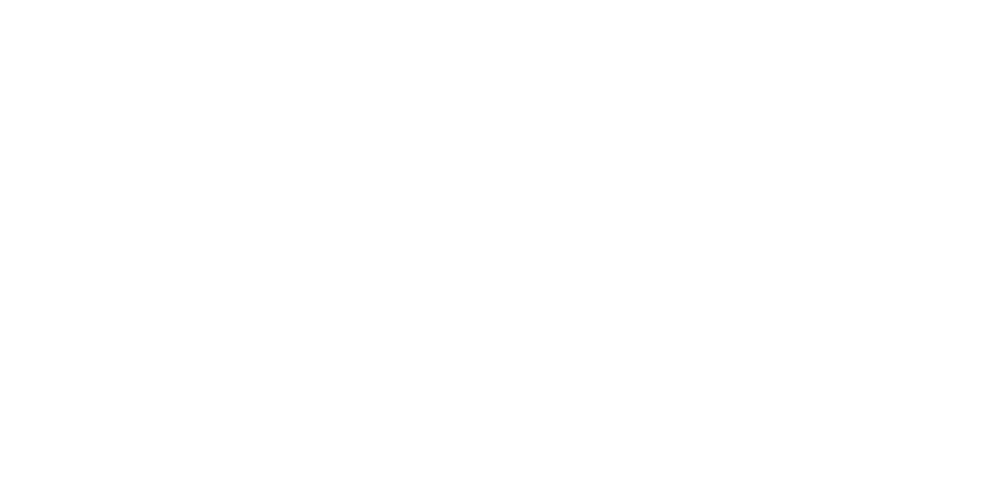

<IPython.core.display.Javascript object>


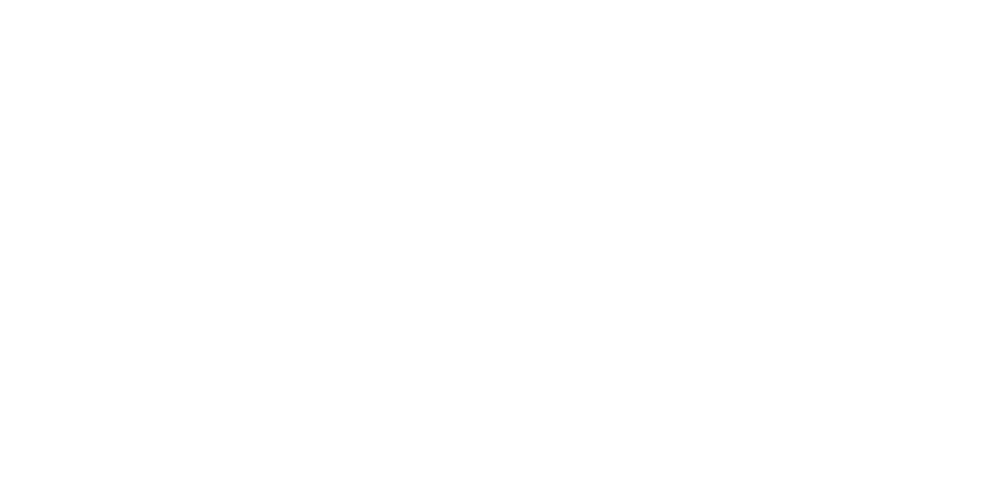

<IPython.core.display.Javascript object>


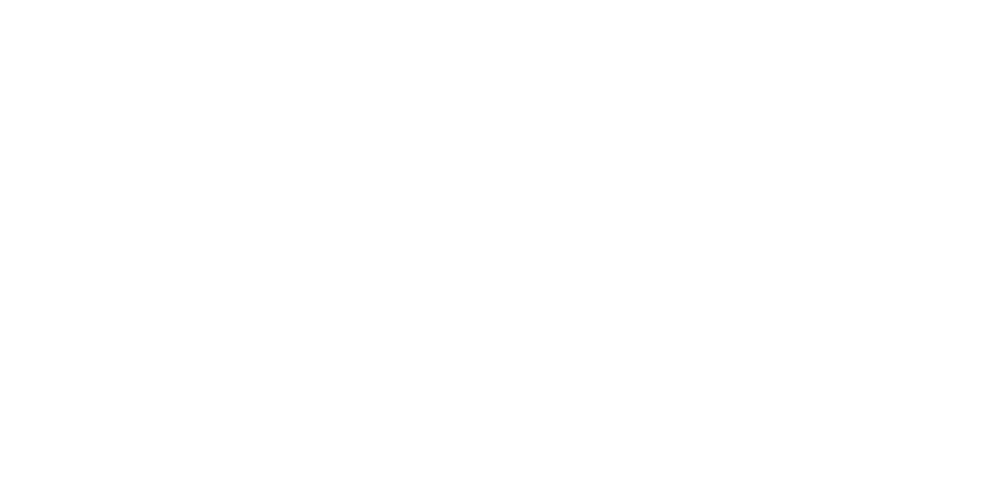

<IPython.core.display.Javascript object>


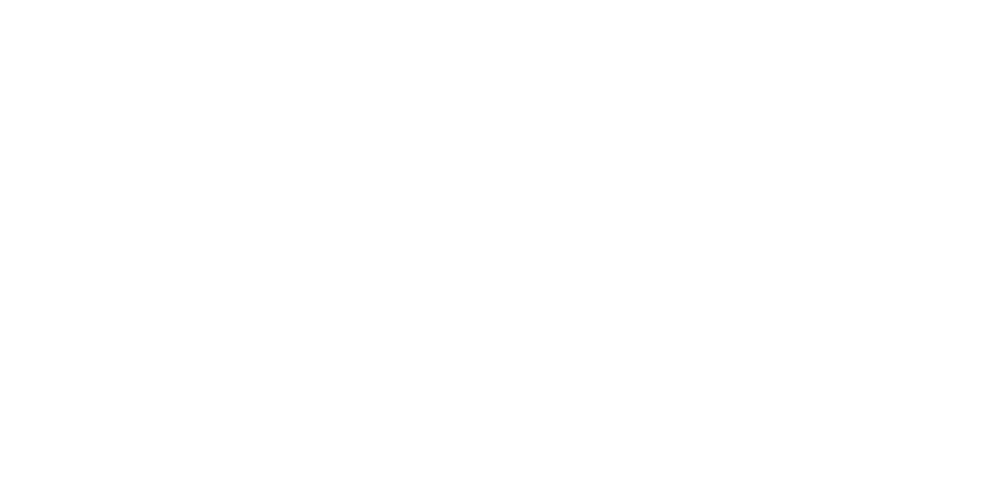

<IPython.core.display.Javascript object>


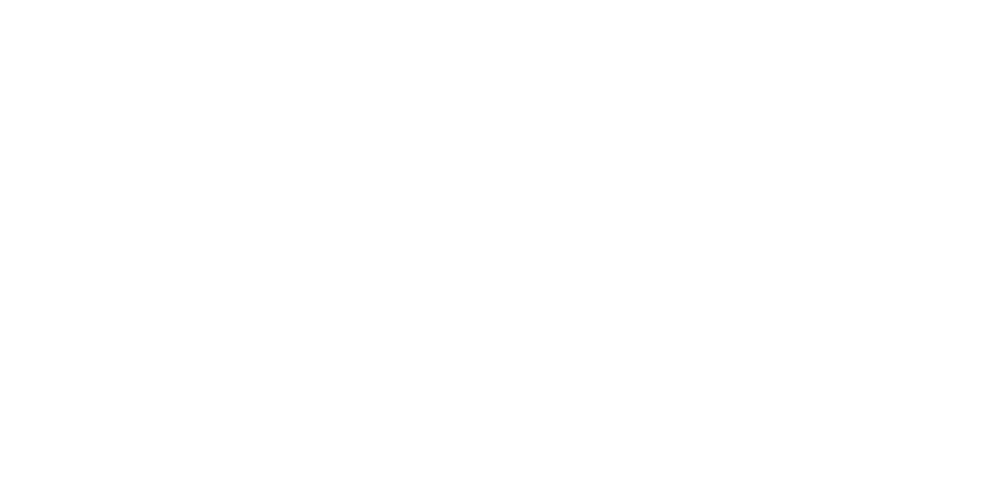

<IPython.core.display.Javascript object>


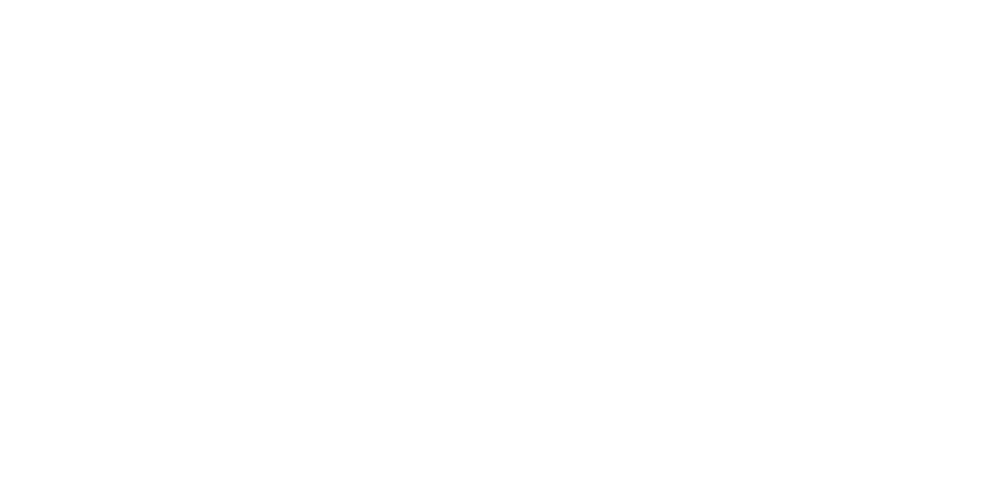

<IPython.core.display.Javascript object>


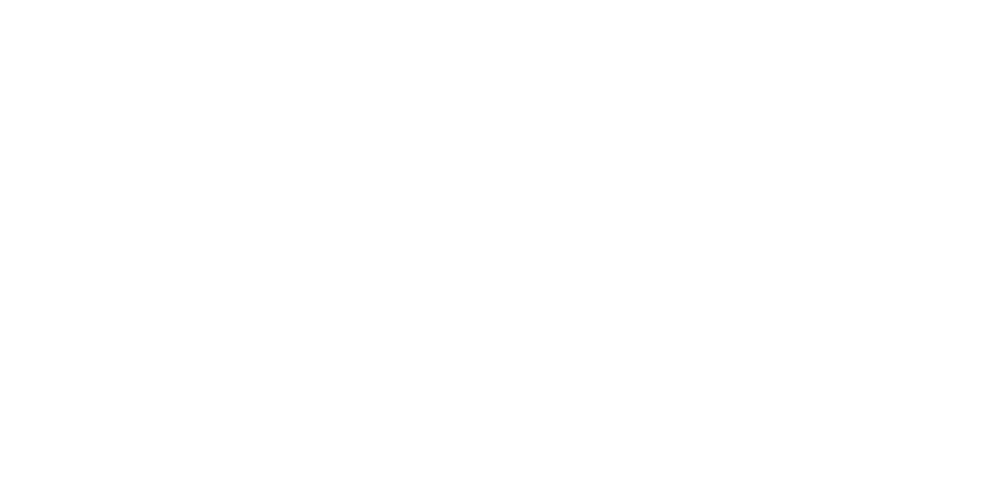

<IPython.core.display.Javascript object>


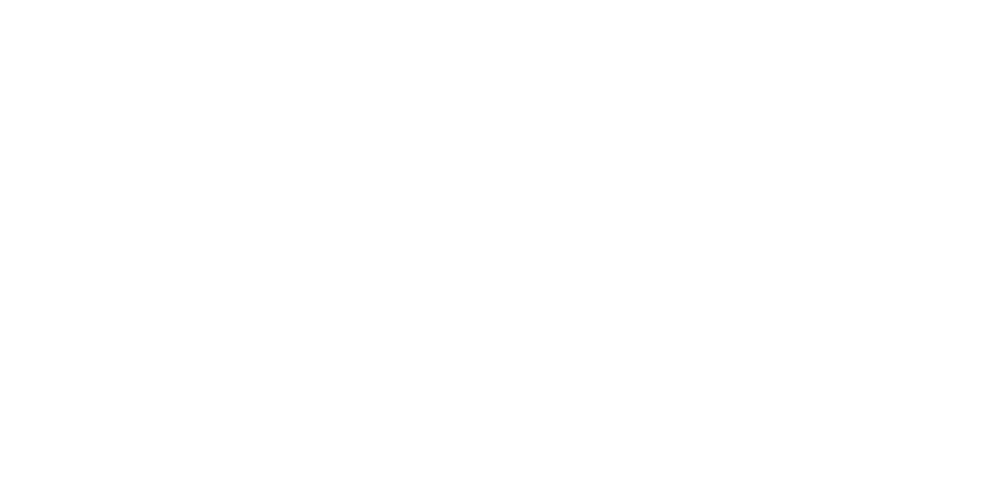

<IPython.core.display.Javascript object>


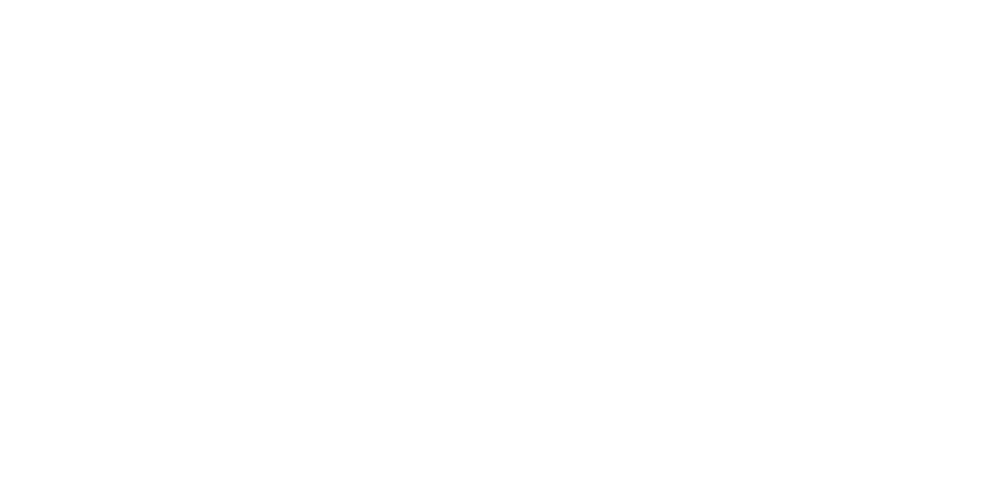

<IPython.core.display.Javascript object>


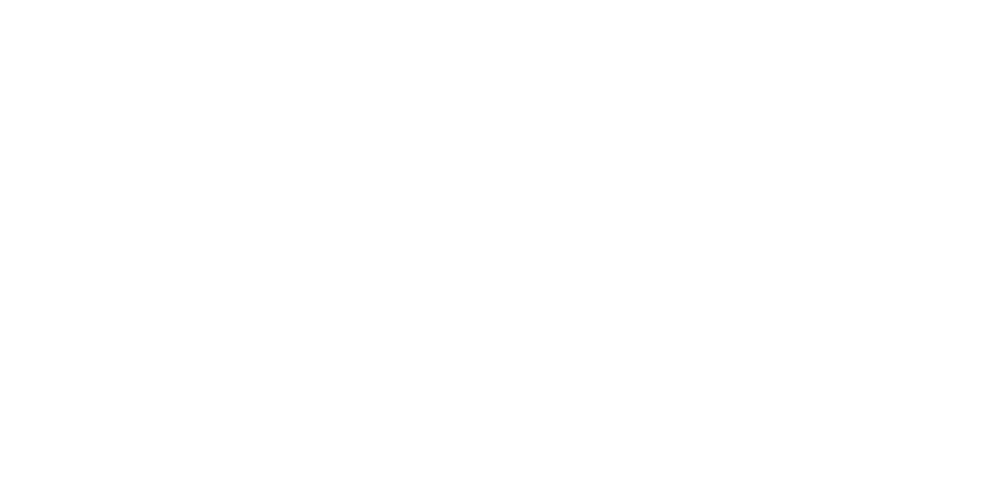

<IPython.core.display.Javascript object>


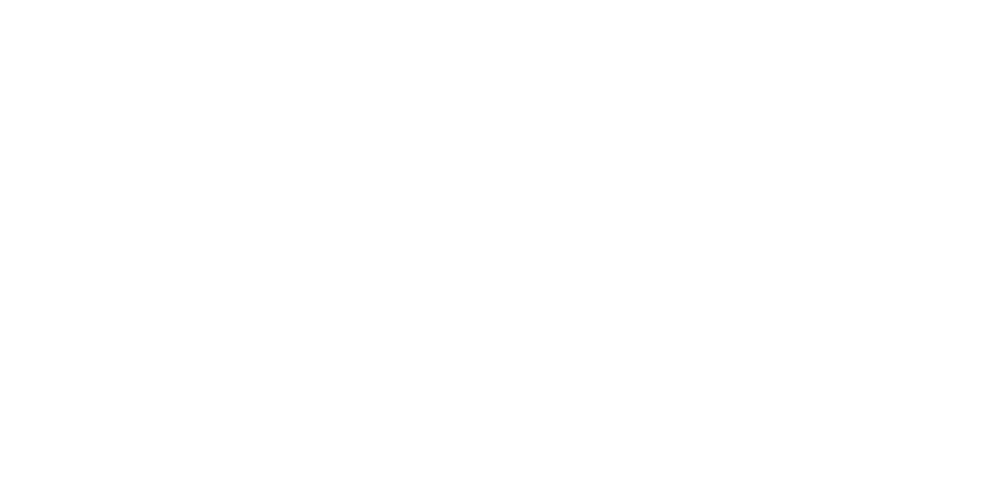

<IPython.core.display.Javascript object>


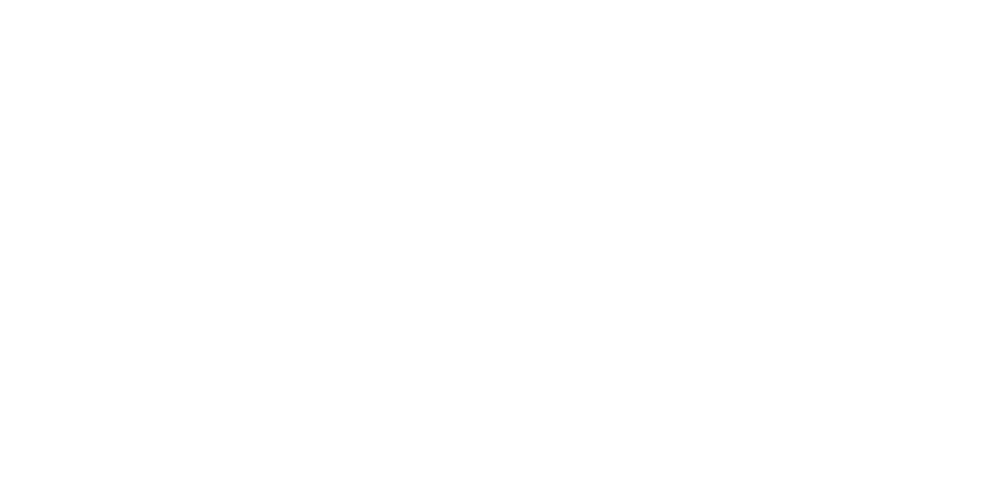

<IPython.core.display.Javascript object>


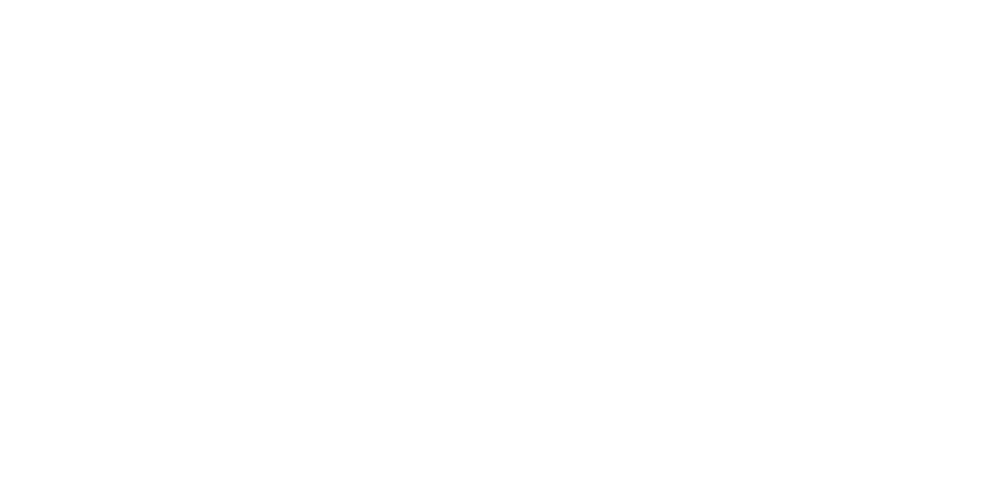

<IPython.core.display.Javascript object>


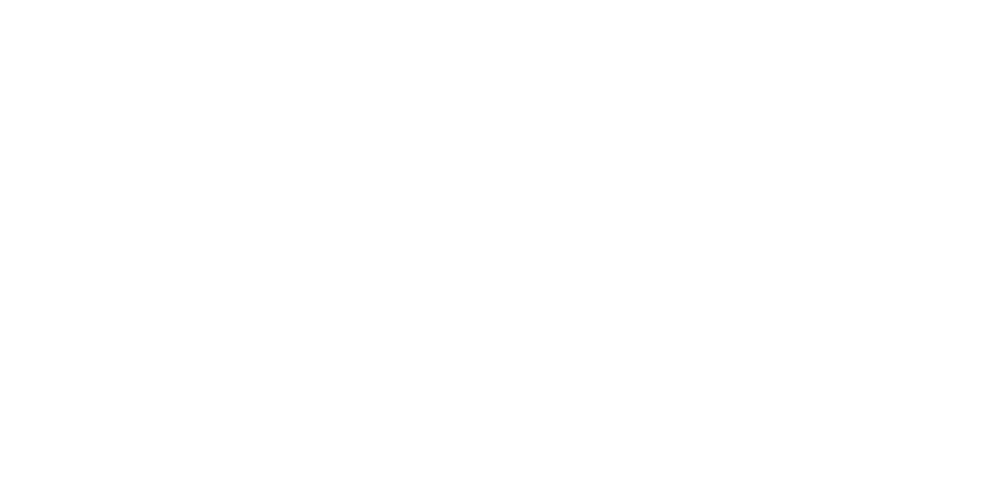

<IPython.core.display.Javascript object>


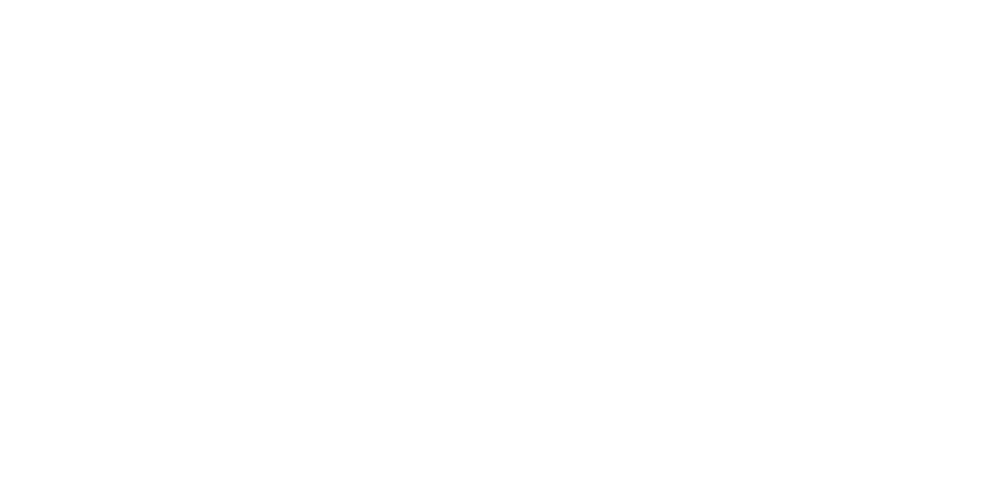

<IPython.core.display.Javascript object>


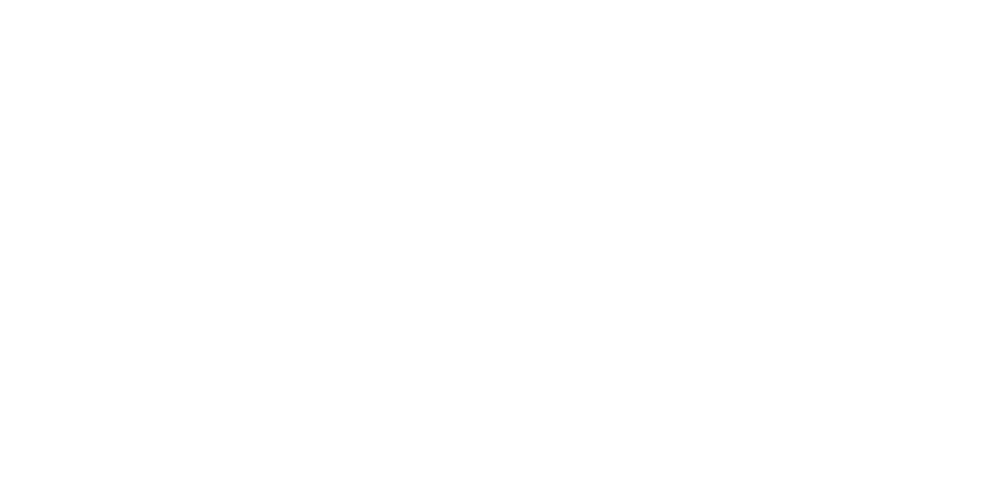

<IPython.core.display.Javascript object>


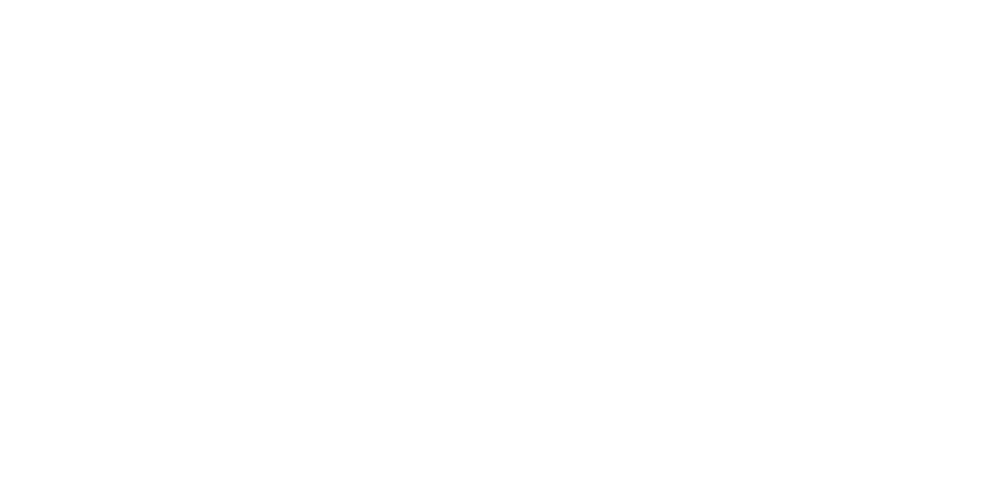

<IPython.core.display.Javascript object>


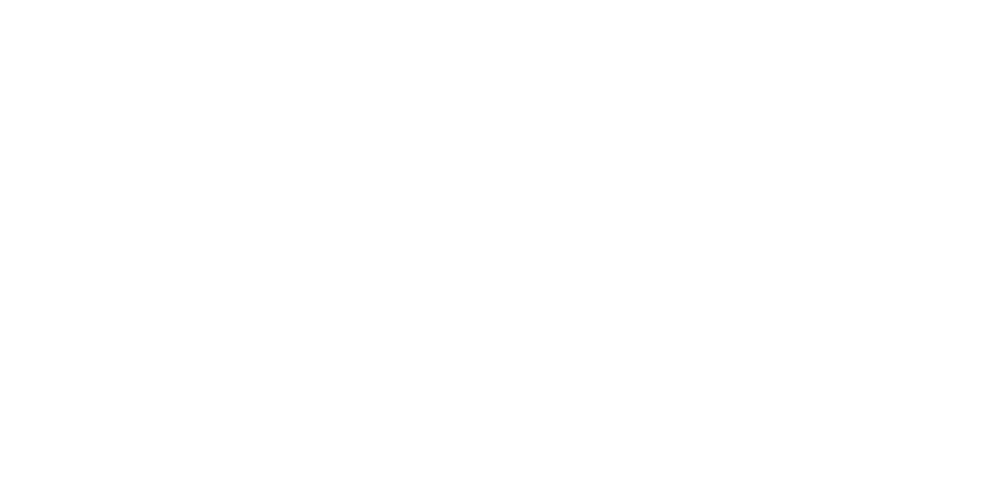

<IPython.core.display.Javascript object>


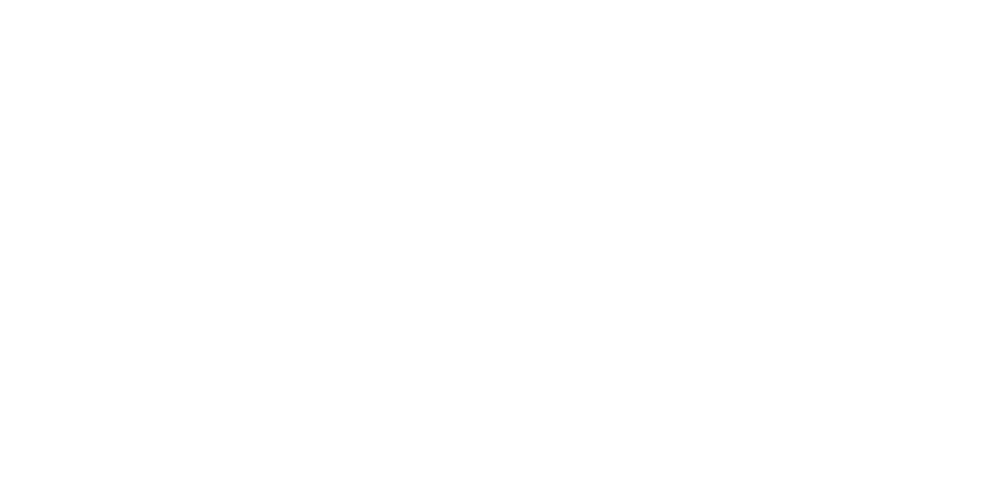

<IPython.core.display.Javascript object>


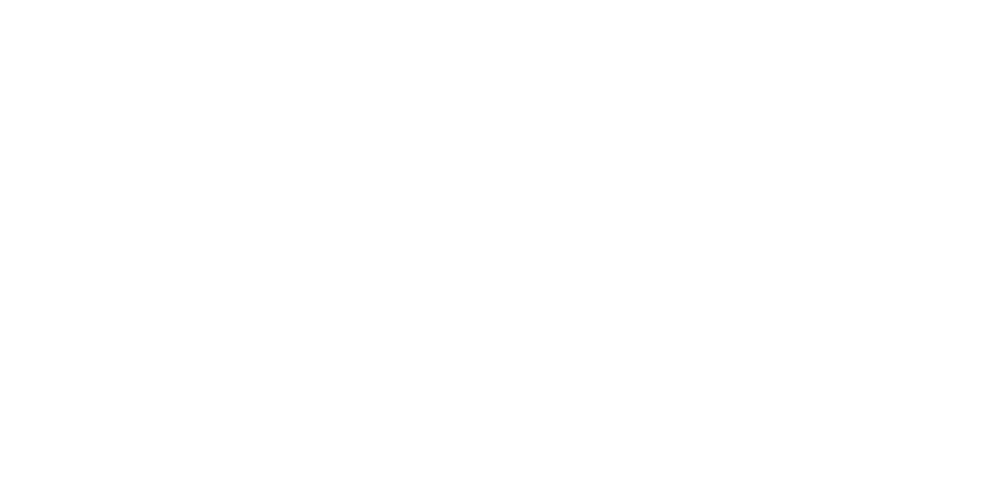

<IPython.core.display.Javascript object>


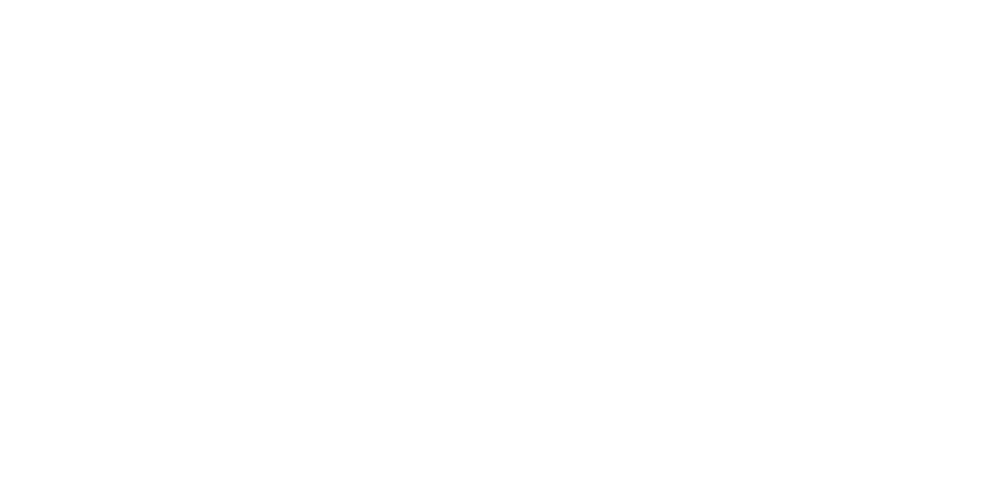

<IPython.core.display.Javascript object>


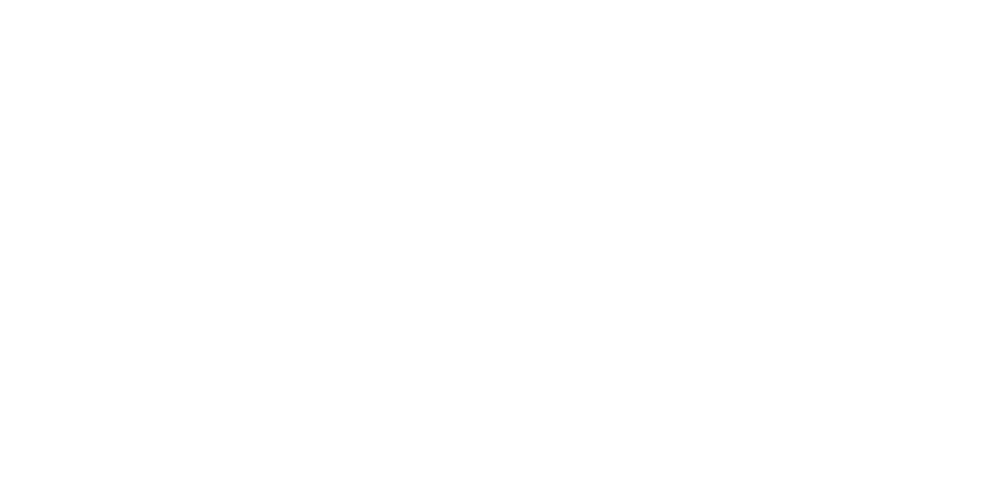

<IPython.core.display.Javascript object>


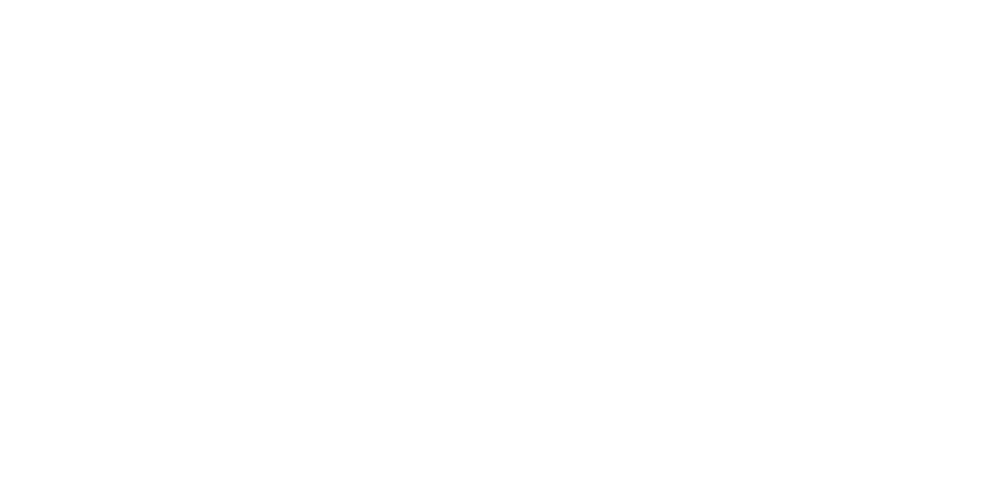

<IPython.core.display.Javascript object>


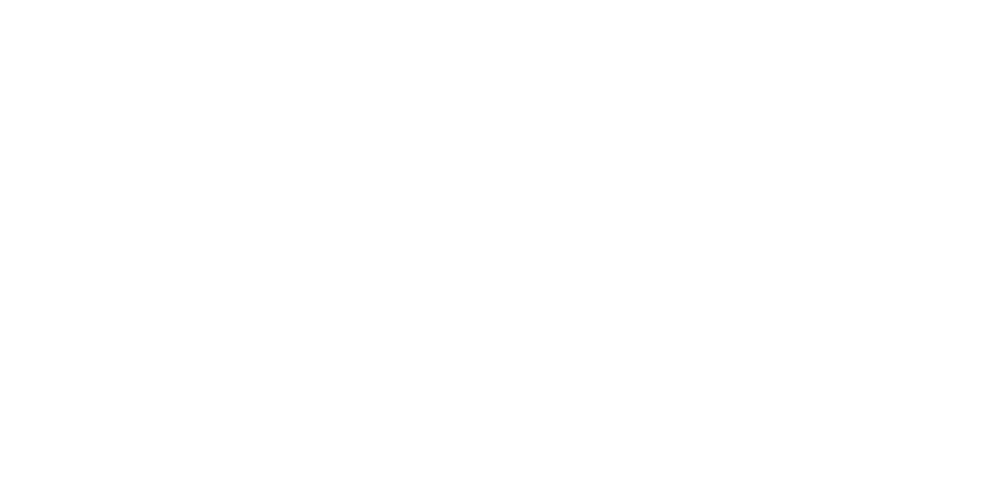

<IPython.core.display.Javascript object>


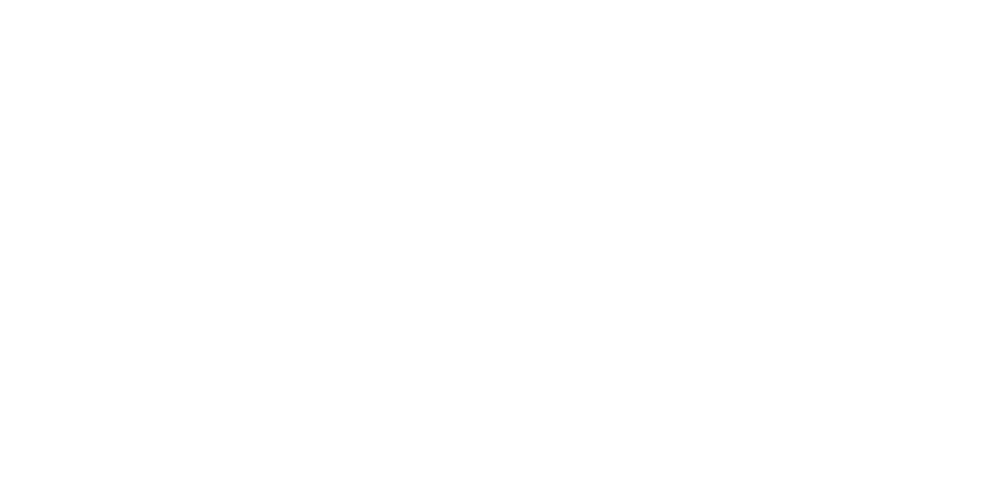

<IPython.core.display.Javascript object>


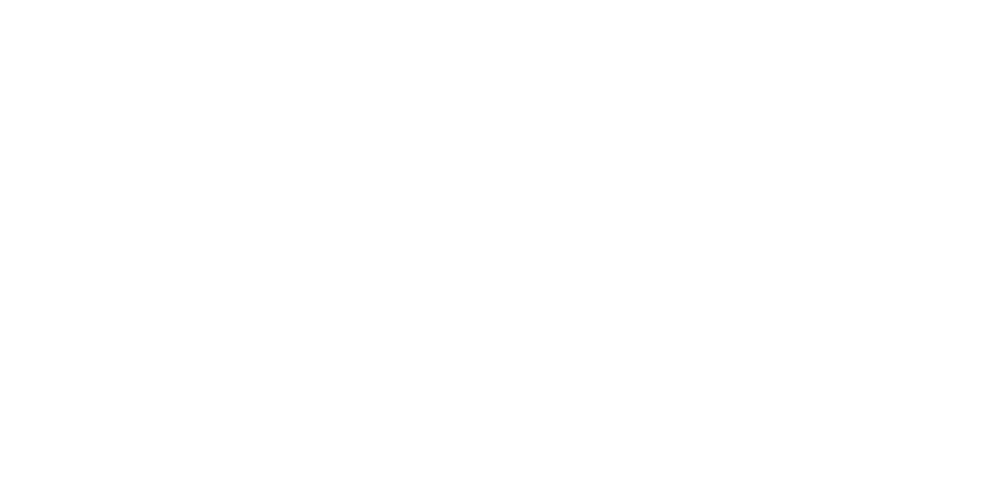

<IPython.core.display.Javascript object>


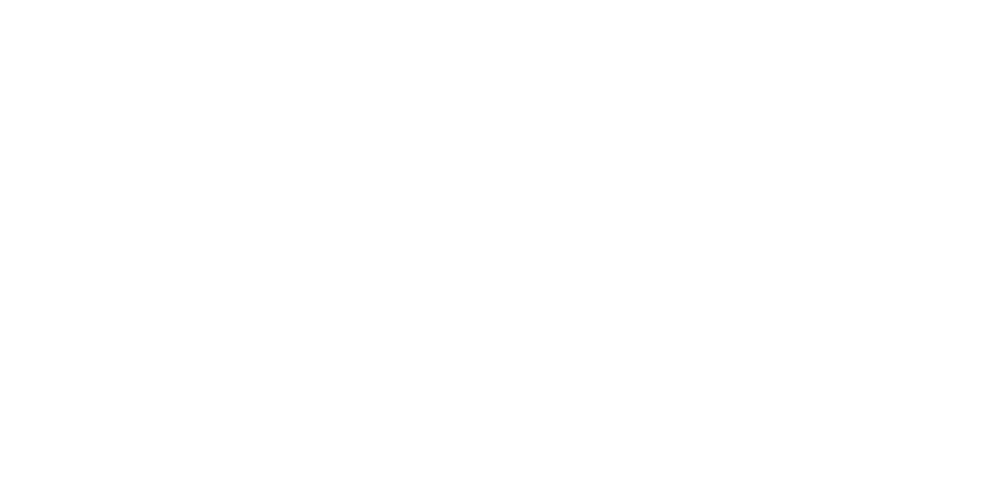

<IPython.core.display.Javascript object>


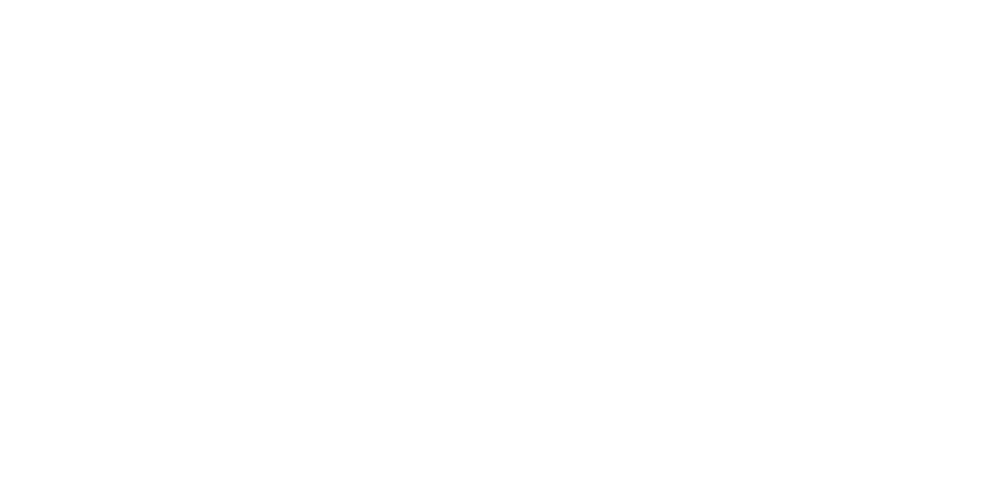

<IPython.core.display.Javascript object>


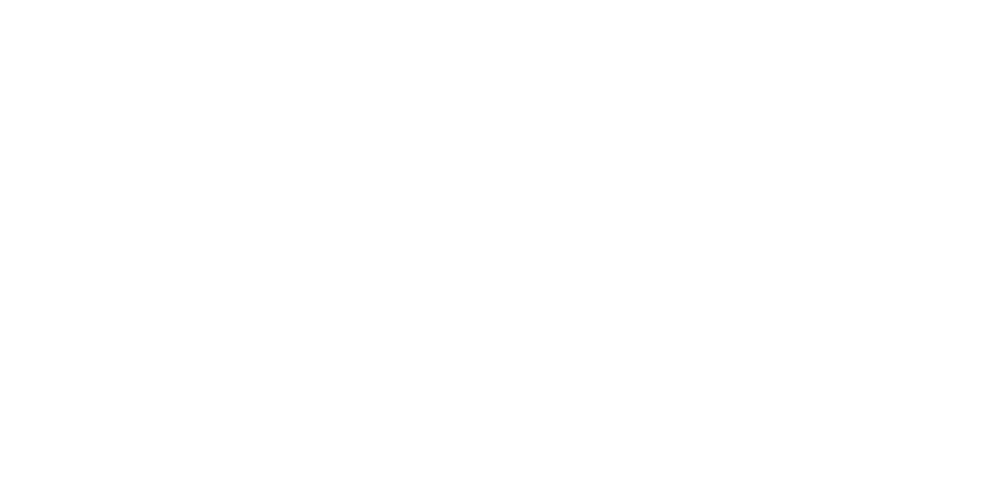

<IPython.core.display.Javascript object>


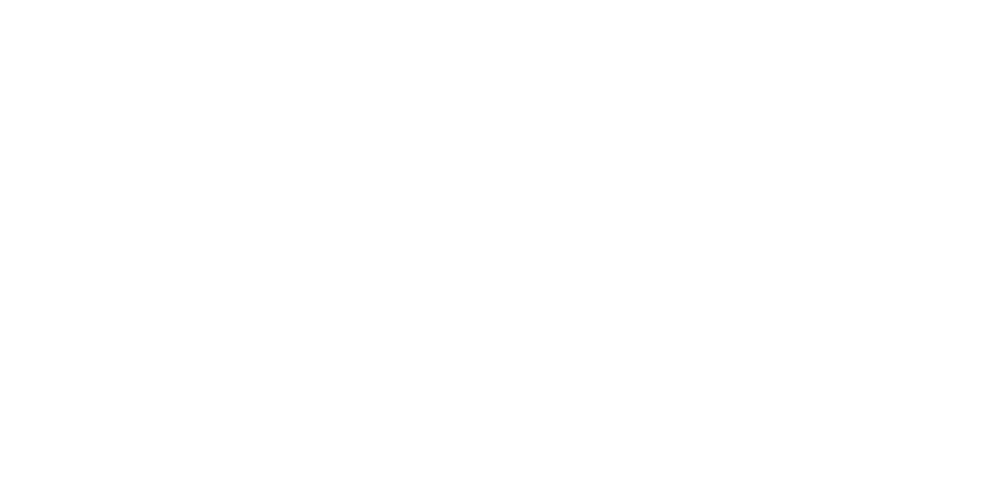

<IPython.core.display.Javascript object>


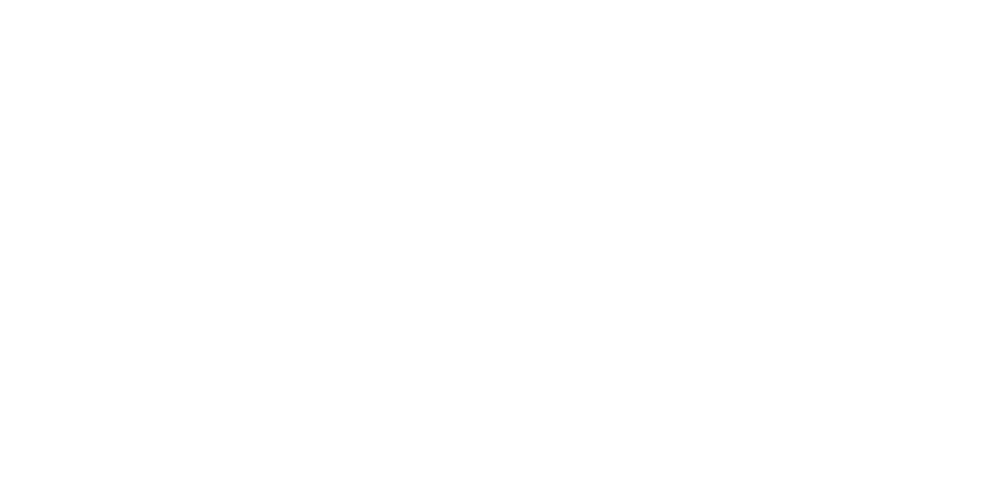

In [21]:
from docx import Document
from docx.shared import Inches
import os
data_of_interest_1 = all_vars
data_of_interest_5 = data_of_interest_1.resample('5T').median().interpolate()
data_of_interest_1h = data_of_interest_1.resample('1H').median().interpolate()
data_of_interest_12 = data_of_interest_1.resample('12H').median().interpolate()
document = Document()
document.add_heading('Time period overview', level=1)
#sections = ['FLUX', 'RESISTANCE', 'PERMEABILITY', 'LAST_TMP']
sections = data_of_interest.columns
for section in sections:
    # cols = [s for s in data_of_interest.columns if section in s]
    cols = section
    # cols = [s for s in cols if 'LAST_FLUX' not in s]
    # for ix, col in enumerate(cols):
    #     data_of_interest[col] = data_of_interest[col].loc[~masks[ix]]
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    plt.grid()
    plt.title(cols)
    plt.xticks(rotation=45)
    
    plt.plot(data_of_interest_1[cols], color='k')
    plt.plot(data_of_interest_12[cols], color='r')
    
    plt.savefig('timeseries.png', bbox_inches='tight')
    plt.close()
    document.add_picture('timeseries.png', width=Inches(6))
    os.remove('timeseries.png')

document.save('Timeseries_apr2020.docx')